In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env THEANO_FLAGS=device=gpu2,floatX=float32

env: THEANO_FLAGS=device=gpu2,floatX=float32


In [3]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import *

import matplotlib.pyplot as plt
%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 2: Tesla K80 (CNMeM is enabled with initial size: 19.0% of memory, cuDNN 5110)


In [4]:
#!mkdir sasha_rnn 
# !wget https://www.dropbox.com/s/fxbjs8gebdm7lkv/sp.json?dl=0 -O sp.json
# !wget https://www.dropbox.com/s/ongjlpx798h8ysq/tinytitles.txt?dl=0 -O tinytitles.txt
# !wget https://www.dropbox.com/s/fqhq3v7h1d67e4e/tokens.txt?dl=0 -O tokens.txt
# !wget https://www.dropbox.com/s/l72wr3fqk3wio44/weights_persona.pcl?dl=0 -O weights_persona.pcl
# !wget https://www.dropbox.com/s/pfg0lx5c17r68tw/weights.pcl?dl=0 -O weights.pkl
# !wget https://www.dropbox.com/s/6igoxt5cji02m5e/names_new.txt?dl=0 -O names_new.txt

## tokens

In [4]:
NAMES_FILENAME = "names_new.txt"
TOKENS_FILENAME = "tokens.txt"

In [5]:
with open(NAMES_FILENAME) as fin:
    names = list(filter(len, fin.read().split('\n')))

In [6]:
names[:10]

['dr._oz',
 'human_wendy',
 'whoopi',
 'kkk_leader',
 'an_official',
 'woodsy_owl',
 'captain',
 'ozzy',
 'geraldo',
 'male_anchor']

In [7]:
with open(TOKENS_FILENAME) as fin:
    tokens = list(filter(len, fin.read().split('\n')))
 
tokens = tokens[:33646] + [name.strip('_').lower() for name in tokens[33646:]]

tokens.append("_BOS_") #beginning of sentence. Omitted in danet
tokens.append("_PAD_") #padding. Omitted in danet

#tokens += names

UNK_ix, BOS_ix, EOS_ix, PAD_ix = list(map(tokens.index, ["_UNK_","_BOS_","_EOS_","_PAD_"]))
n_tokens = len(tokens)

from collections import defaultdict
token_to_ix = defaultdict(lambda : UNK_ix, {t:i for i, t in enumerate(tokens)})

In [8]:
name_to_ix = defaultdict(lambda : UNK_ix, {t:i for i, t in enumerate(names)})

In [9]:
import regex
import numpy as np

def preprocess(lines, max_len=20, speaker=None, add_eos=True):
    if type(lines) == (str):
        lines = [lines]
    
    context=[]
    for line in lines:
        line = line.lower()
        line = regex.sub(r'(\p{P}|`|~)', r' \1 ', line)
        line_ix = list(map(token_to_ix.__getitem__, filter(len, line.split())))
        if add_eos:
            line_ix.append(EOS_ix)
        context += line_ix
            
    if speaker is not None:
        context.append(speaker)
        
    return context

def ix_to_matrix(phrases_ix, max_len=None):
    max_len = max_len or max(map(len,phrases_ix))
    
    matrix = np.zeros((len(phrases_ix),max_len),dtype='int32') + PAD_ix
    
    for i,phrase_ix in enumerate(phrases_ix):
        matrix[i,:min(len(phrase_ix),max_len)] = phrase_ix[:max_len]
        
    return matrix

def phrase_to_matrix(contexts, max_len=None, **kwargs):
            
    return ix_to_matrix([preprocess(phrases,**kwargs) for phrases in contexts], max_len=max_len)

In [10]:
len(tokens)

36071

In [11]:
phrase_to_matrix(["Hello dude!!!"])

array([[13885, 34723,    14,    14,    14,     0]], dtype=int32)

In [ ]:
def generate_data(data_rows, batch_size=32, speakers_list=None, context_length=3, max_len=20, n_iter=np.inf):
    i=0

    while True:
        batch_ix = np.random.randint(0, len(data_rows) - context_length - 1, batch_size)
        context_ix = batch_ix[:, None] + np.arange(context_length)[None, :]
        answer_ix = batch_ix + context_length
        batch_x = ix_to_matrix(list(map(np.concatenate, data_rows[context_ix])), max_len=max_len)
        batch_y = ix_to_matrix(data_rows[answer_ix], max_len=max_len)
        if speakers_list == None:
            yield batch_x, batch_y
        else:
            respondent = speakers_list[answer_ix]
            yield batch_x, batch_y, respondent
        i+=1
        if i >= n_iter:
            break

### Load data

In [ ]:
import json
from pprint import pprint

with open('sp.json', 'r') as fn:    
    data = json.load(fn, encoding='cp1251')
    
    
import re
numbers_regex = re.compile('#?[0-9]+')

def preprocess_speaker_name(name):
    try:
        str(name)
    except:
        return ''
    name_parts = map(str.lower, str(name).split())
    filtered = filter(lambda part: not re.match(numbers_regex, part), name_parts)
    return '_'.join(filtered)

data_rows = np.array([preprocess(lines=[phrase[1]])
                      for part in data for phrase in part['conversation'] if phrase[0] and phrase[1] 
                      and len(phrase[0]) > 2])

speakers_list = np.array([name_to_ix[preprocess_speaker_name(phrase[0][:-2])]
                      for part in data for phrase in part['conversation'] if phrase[0] and phrase[1] 
                          and len(phrase[0]) > 2])

# model

In [12]:
from warnings import warn
import numpy as np
import theano
theano.config.floatX='float32'
import theano.tensor as T

In [13]:
theano.config.exception_verbosity='high'

In [14]:
grad_clipping = 5
lstm_units = 1024
emb_size = 512
bottleneck_units = 256
person_emb_size = 100
seq_len = 20
sampling_num = 5
n_persons = len(names)
temperature = theano.shared(np.float32(1.))


In [15]:
from sasha_rnn.wrong_lstm_layer import WrongLSTMLayer
from lasagne.layers import *

class encoder:
        
    input_phrase = T.imatrix("encoder phrase tokens")
    
    l_in = InputLayer((None,None), input_phrase, name='context input')
    l_mask = InputLayer((None,None), T.neq(input_phrase, PAD_ix), 'context mask')
    
    l_emb = EmbeddingLayer(l_in, n_tokens, emb_size, name="context embedding")
    
    
    ####LSTMLayer with incorrect outputgate####
    
    l_lstm = WrongLSTMLayer(
                        l_emb,
                        lstm_units,
                        name='encoder_lstm',
                        grad_clipping=grad_clipping,
                        mask_input=l_mask,
                        only_return_final=True,
                        peepholes=False)
    
    output = l_lstm



In [16]:
n_persons = len(names)
person_id_var = T.ivector("personality idxs")
l_person_id = InputLayer((None,), person_id_var)
l_person_emb = EmbeddingLayer(l_person_id, n_persons, person_emb_size, name="persona_based.emb")

In [17]:
LATENT_SIZE = n_persons
latent_c = T.imatrix("latent variable for InfoGAN")
#l_latent = InputLayer((None, LATENT_SIZE), input_var=latent_c)

def sample_c(respondents):
    return np.eye(LATENT_SIZE)[respondents]

In [18]:
from sasha_rnn.wrong_lstm_cell import WrongLSTMCell
from agentnet import Recurrence
from agentnet.resolver import  ProbabilisticResolver

class decoder:
    prev_cell = InputLayer((None,lstm_units), name='cell')
    prev_out = InputLayer((None,lstm_units), name='out')
    
    
    
    #input
    inp_word = InputLayer((None,))
    word_embedding = EmbeddingLayer(inp_word, n_tokens, emb_size,
                                         W=encoder.l_emb.W, name='emb')
    encoder_lstm = InputLayer((None, lstm_units), name='encoder')
    person_emb = InputLayer((None, person_emb_size), name='persona_based.each_tick')

    #recurrent units
    new_cell,new_out = WrongLSTMCell(prev_cell, prev_out,
                                     input_or_inputs=[word_embedding, encoder_lstm, person_emb],#, inp_c],
                                     name='decoder_lstm', peepholes=False
                                    )
    

    bottleneck = DenseLayer(new_out, bottleneck_units,
                              nonlinearity=T.tanh,
                              name='decoder intermediate')

    
    next_word_probs = DenseLayer(bottleneck, n_tokens,
                                 nonlinearity=lambda probs: T.nnet.softmax(probs/temperature),
                                 name='decoder next word probas')

    next_words = ProbabilisticResolver(next_word_probs, assume_normalized=True)
    
    



In [19]:
def get_mask_from_end_indicator(end_indicator):
    return T.concatenate([T.ones_like(end_indicator[:,:1]),
                          T.eq(T.cumsum(end_indicator,axis=1), 0)[:,:-1]], axis=1)

In [20]:
class generator:
    
    n_steps = T.iscalar()
    
    bos_input_layer = InputLayer((None,),T.zeros((encoder.input_phrase.shape[0],), 'int32')+BOS_ix, name="first input")

    recurrence = Recurrence(
                           input_nonsequences={decoder.encoder_lstm: encoder.output,
                                               decoder.person_emb: l_person_emb},
                                               #decoder.inp_c: l_latent},
                           state_variables={decoder.new_cell: decoder.prev_cell,
                                            decoder.new_out: decoder.prev_out,
                                            decoder.next_words: decoder.inp_word},
                           tracked_outputs=[decoder.next_words, decoder.next_word_probs, decoder.new_cell, 
                                            decoder.new_out],
                           state_init={decoder.next_words: bos_input_layer},
                           n_steps=n_steps,
                           unroll_scan=False,)
    
    weights = get_all_params(recurrence, trainable=True)    
    
    rec_output = get_output(recurrence)

    out, probs, cell_seq, out_seq=rec_output[decoder.next_words],T.maximum(rec_output[decoder.next_word_probs],1e-10),\
                                               rec_output[decoder.new_cell], rec_output[decoder.new_out]
    
    mask = get_mask_from_end_indicator(T.eq(out, EOS_ix))
    auto_updates = recurrence.get_automatic_updates()
    
    generate = theano.function([encoder.input_phrase, person_id_var, n_steps], out,
                                updates=auto_updates, allow_input_downcast=True)
    
    #Greedy mode
    greedy_out = get_output(recurrence[decoder.next_words], recurrence_flags={"greedy": True})
    
    greedy_auto_updates = recurrence.get_automatic_updates()
    greedy_mask = get_mask_from_end_indicator(T.eq(greedy_out, EOS_ix))
    
    generate_greedy = theano.function([encoder.input_phrase, person_id_var, n_steps], greedy_out,
                                       updates=greedy_auto_updates, allow_input_downcast=True)
    
    # Perplexity 
    from agentnet.learning.generic import get_values_for_actions
    choosen_probs = get_values_for_actions(probs, out)
    perplexity = T.mean(T.power(2, -T.sum(T.log(choosen_probs), axis=-1) / n_steps))
    
    get_perplexity_fn = theano.function([encoder.input_phrase, person_id_var, n_steps], perplexity,
                                updates=auto_updates, allow_input_downcast=True)


    @staticmethod
    def reply(phrase, person_id, max_len=20, **kwargs):
        phrase_ix = phrase_to_matrix([phrase], **kwargs)

#         latent = sample_c([person_id])
        answer_ix = generator.generate(phrase_ix, [person_id], max_len)[0]
        if EOS_ix in answer_ix:
            answer_ix = answer_ix[:list(answer_ix).index(EOS_ix)]
        return ' '.join(map(tokens.__getitem__, answer_ix))
    
    

In [24]:
one_batch = generate_data(data_rows, speakers_list=speakers_list, n_iter=1, max_len=seq_len).next()


/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [25]:
def phrase_from_idx(idxs, crop_by_eos=False):
    if crop_by_eos and EOS_ix in idxs:
        idxs = idxs[:list(idxs).index(EOS_ix)]
        
    phrase_tokens = map(tokens.__getitem__, idxs)
    return phrase_tokens

In [59]:
name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)

conversation_names = set(names) & set(tokens)

conversation_name_idxs = map(name_to_ix.get, conversation_names)
conversation_token_idxs = map(token_to_ix.get, conversation_names)

name_batch_repeated = np.repeat(name_batch, len(conversation_names), axis=0)

latent_for_name_batch = sample_c(conversation_name_idxs)


def accuracy_in_names():
    #model_answers = generator.generate(name_batch_repeated, conversation_name_idxs, 20, latent_for_name_batch)
    model_answers = [generator.generate(name_batch, [name_idx], 20) 
                                        for name_idx in conversation_name_idxs]
    def crop_by_eos(answer):
        if  EOS_ix in answer:
            return answer[:list(answer).index(EOS_ix)]
        return answer
        
    res = map(lambda answer, name_idx: name_idx in set(crop_by_eos(answer[0])), model_answers, conversation_token_idxs)   
    matched_idxs = np.where(res)[0]
    name_idxs = [conversation_name_idxs[idx] for idx in matched_idxs]
    matched_names = [names[idx] for idx in name_idxs]
    
    matched_answers = [' '.join(phrase_from_idx(model_answers[idx][0], crop_by_eos=True)) for idx in matched_idxs] 
    return matched_names, matched_answers
    return sum(res)

In [21]:
# import pickle
# with open("weights_persona.pcl", 'rb') as f:
#     d = pickle.load(f)
    
# d[0] = (np.random.normal(size=n_persons * person_emb_size).reshape((n_persons, person_emb_size)) * 1e-10).astype('float32')

In [27]:
import pickle
with open("generator_ent_weights.pkl", 'rb') as f:
    d1 = pickle.load(f)

In [28]:
gen_params = get_all_params(generator.recurrence)
for i in range(1, 16):
    gen_params[i].set_value(d1[i - 1])
gen_params[0].set_value(d1[15])
i = 16
for param in gen_params[16:]:
    if param.get_value().shape == d1[i].shape:
        param.set_value(d1[i])
        i += 1

In [29]:
temperature.set_value(np.float32(0.5))
for i in range(5):
    print(generator.reply(["Hello!", "Hello", "What is your name ?"], 2484))
    
temperature.set_value(np.float32(1))

my name is harry and i ' m the president ' s old pal , but i ' m sure
my name is dan snyder . i ' m a very special little boy .
my name is dr . biber .
my name is dr . biber .
my name is dr . biber .


In [30]:
emb_weights = d1[0]

In [31]:
emb_weights.shape

(36071, 512)

In [33]:
from custom_layers import SrcTrgToMatrixLayer
from lasagne.nonlinearities import *

class conv_discriminator:
#     questions_var = T.imatrix(name='questions var')
    reference_answers_var = T.imatrix(name='reference answers var')

    question = InputLayer((None, 20), name='question')
    answer = InputLayer((None, 20), name='answer')

    question_emb = EmbeddingLayer(question, emb_weights.shape[0], emb_weights.shape[1], W=emb_weights)
    answer_emb = EmbeddingLayer(answer, emb_weights.shape[0], emb_weights.shape[1], W=emb_weights)

    cnn_input = SrcTrgToMatrixLayer(question_emb, answer_emb)

    nn = Conv2DLayer(cnn_input, 20, (3, 3), nonlinearity=None)
    nn = Pool2DLayer(nn, (2, 2))
    nn = Conv2DLayer(nn, 20, (3, 3), nonlinearity=None)
    nn = Pool2DLayer(nn, (2, 2))
    
    dense = DenseLayer(nn, 20, nonlinearity=None)
    l_prob = DenseLayer(dense, 2, nonlinearity=softmax)
    
    #dense_q = DenseLayer(nn, LATENT_SIZE * 2, nonlinearity=None)
    #dense_q = ReshapeLayer(dense_q, (LATENT_SIZE, 2), nonlinearity=softmax)
    l_Q = DenseLayer(nn, LATENT_SIZE, nonlinearity=softmax)

    
    output_on_fake, q_out = get_output([l_prob, l_Q], {question: encoder.input_phrase, answer: generator.out})
    #q_probs = q_out[:, :, 1]
    q_entropy = (latent_c * T.log(q_out)).sum(axis=-1).mean()

    info_approximation = q_entropy                              
    output_on_greedy_fake = get_output(l_prob, {question: encoder.input_phrase, answer: generator.greedy_out})
    output_on_real = get_output(l_prob, {question: encoder.input_phrase, answer: reference_answers_var})
    
    loss = -T.log(output_on_fake[:, 0]).sum() - T.log(output_on_real[:, 1]).sum() - 0.001 * info_approximation

    weights = get_all_params(l_prob, trainable=True) + get_all_params(l_Q, trainable=True)
    weights.remove(question_emb.W)
    weights.remove(answer_emb.W)

    updates = generator.auto_updates + lasagne.updates.adam(loss, weights, learning_rate=0.0001) 
    
    train_step = theano.function([encoder.input_phrase, reference_answers_var, person_id_var, generator.n_steps, latent_c], 
                                 [loss, info_approximation], 
                                 updates=updates,
                                allow_input_downcast=True)

In [71]:
get_discr_out_on_fake = theano.function([encoder.input_phrase, person_id_var, generator.n_steps],
                                        conv_discriminator.output_on_fake[:, 1], updates=generator.auto_updates,
                                        allow_input_downcast=True)

get_discr_out_on_real = theano.function([encoder.input_phrase, conv_discriminator.reference_answers_var], 
                                        conv_discriminator.output_on_real[:, 1],
                                        allow_input_downcast=True)

In [61]:
from agentnet.utils.persistence import save, load
save(conv_discriminator.l_prob, 'conv_infoent_discr_l_prob.pkl')

In [62]:
save(conv_discriminator.l_Q, 'conv_infoent_discr_l_Q.pkl')

In [36]:
test_discr_fn = theano.function([encoder.input_phrase, person_id_var, generator.n_steps], 
                                [generator.out, conv_discriminator.output_on_fake], updates=generator.auto_updates,
                               allow_input_downcast=True)

In [49]:
class trainer:
    reference_answers = T.imatrix("decoder reference answers")
    
    bos_column = T.zeros((reference_answers.shape[0], 1), 'int32') + BOS_ix
    reference_answers_bos = T.concatenate((bos_column, reference_answers), axis=1)  #prepend BOS
        
    l_ref = InputLayer((None, None), reference_answers_bos, name='context input')
    l_ref_mask = InputLayer((None,None), T.neq(reference_answers_bos, PAD_ix), 'context mask')

    recurrence = Recurrence(input_sequences={decoder.inp_word:l_ref},
                           input_nonsequences={decoder.encoder_lstm:encoder.output,
                                               decoder.person_emb:l_person_emb},
                           state_variables={decoder.new_cell:decoder.prev_cell,
                                            decoder.new_out:decoder.prev_out,},
                           tracked_outputs=[decoder.next_word_probs],
                           mask_input=l_ref_mask,
                           unroll_scan=False,)
    
    
    P_seq = get_output(recurrence[decoder.next_word_probs])
    #V_seq = whateveryouadded
    
    ############################
    ###loglikelihood training###
    ############################
    predicted_probas = P_seq[:, :-1].reshape((-1, n_tokens)) + 1e-6
    target_values = reference_answers.ravel()

    llh = lasagne.objectives.categorical_crossentropy(predicted_probas, target_values)
    llh_loss = llh.mean()
    llh_updates = lasagne.updates.adam(llh_loss, generator.weights, 0.001)

    train_llh_step = theano.function([encoder.input_phrase, person_id_var, reference_answers],
                                     llh_loss, updates=llh_updates, allow_input_downcast=True)
    get_llh = theano.function([encoder.input_phrase, person_id_var, reference_answers], llh_loss,
                             allow_input_downcast=True)
    

In [37]:
def plot_smoothed(x, n=10):
    smoothed_x = [np.mean(x[i-n:i]) for i in range(n, len(x))]
    plt.plot(smoothed_x)

In [37]:
pretrain_discr_loss = []

In [38]:
pretrain_latent_gen = []

In [39]:
infolosses = []

In [99]:
2.73 ** -6.

0.002415594976401036

In [40]:
for bx, by, respondent in generate_data(data_rows, speakers_list=speakers_list, n_iter=10000, max_len=seq_len):
    err, infoloss = conv_discriminator.train_step(bx, by, respondent, 20, sample_c(respondent))
    #gen_err = trainer.train_llh_step(bx, respondent, by)
    pretrain_discr_loss.append(err)
    infolosses.append(infoloss)
    print "%.5f"%err, "%.5f"%infoloss

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


51.33558 -8.07154
48.27124 -8.06815
47.90277 -8.05942
46.26079 -8.06295
45.94870 -8.05252
44.54993 -8.03546
43.29191 -8.07861
43.50407 -8.03985
42.57881 -8.01925
42.49622 -8.04096
40.92238 -8.04824
38.74004 -8.04672
40.17352 -8.04155
37.20708 -8.01773
37.72484 -8.04177
35.93889 -8.03603
36.21176 -8.02493
35.76099 -8.02646
34.16207 -8.05278
32.66802 -8.00296
33.62802 -8.00822
32.24629 -8.02215
34.05779 -8.01364
31.77098 -8.03592
31.86721 -8.04650
24.94081 -8.02475
32.85449 -8.02077
25.30106 -8.01766
28.92288 -7.99068
24.86328 -8.00241
28.81413 -7.98713
28.63487 -7.99489
32.33042 -7.94362
27.50740 -8.00305
28.97284 -7.95000
30.56905 -7.99693
26.86299 -7.98297
27.88584 -8.00121
26.63042 -8.01051
24.10823 -7.96388
28.08673 -7.95902
28.53225 -7.99655
26.71026 -8.00650
29.28932 -8.02359
33.88100 -7.95676
30.54907 -7.97613
31.60169 -7.96014
29.34288 -7.95254
21.61700 -7.92179
25.48066 -7.96908
27.05620 -7.95920
22.52760 -7.92384
31.94356 -7.93392
27.69799 -7.92234
30.20638 -7.88975
24.85527 -

KeyboardInterrupt: 

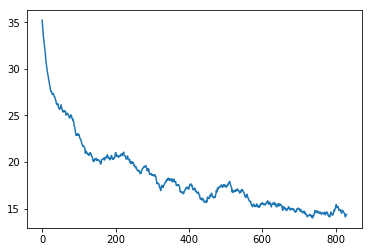

In [41]:
plot_smoothed(pretrain_discr_loss, n=40)

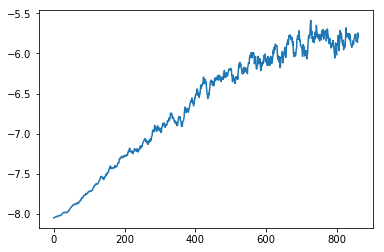

In [42]:
plot_smoothed(infolosses)

In [43]:
for i in range(10):
    name_id = 439
    name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)
    #att_seqs = attention_discriminator.get_attention_fake(name_batch, [name_id], 20)
    gen_answer, gen_reward = test_discr_fn(name_batch, [name_id], 20)
    gen_answer = ' '.join(phrase_from_idx(gen_answer[0], crop_by_eos=True))
    print gen_reward[0, 1]
    print "GENERATED: ", gen_answer

0.00240157
GENERATED:  my name is randy marsh . this is my special battery protocol .
0.525611
GENERATED:  my name is butters , and i ' m _UNK_ ' . i had a guy invited me to my
0.379213
GENERATED:  my name is bubbe marsh , and i ' m pretty special and small and jewish . mysterion , don
0.384388
GENERATED:  my name . . . used to be . . . i know joseph smith . oh god , what
0.0999485
GENERATED:  oh , jesus ! ah you crazy , it ' s the most unbelievable thing !
0.00222513
GENERATED:  jimmy marsh .
0.00657407
GENERATED:  satan . your new priest friend has something to remember with his name .
0.00066202
GENERATED:  butters ?
0.607849
GENERATED:  it ' s my darling mackey . i ' m just making it a holiday special . the answer is
0.0346378
GENERATED:  my name is clyde frog . i ' m special olympics grampa .


In [44]:
gen_answers, gen_rewards = test_discr_fn(one_batch[0], one_batch[2], 20)
gen_answers = [' '.join(phrase_from_idx(gen_answers[j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
answers =  [' '.join(phrase_from_idx(one_batch[1][j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
discr_reward = gen_rewards[:, 1]
#att_seqs = attention_discriminator.get_attention_real(one_batch[0], one_batch[1])
for i in range(one_batch[0].shape[0]):
    print discr_reward[i]
    print ' '.join(phrase_from_idx(one_batch[0][i]))
    print "REAL: ", answers[i]
    print "GENERATED: ", gen_answers[i]

0.00116132
shhh . _EOS_ shut up , cartman ! just face it . we lost this one . _EOS_ kenny .
REAL:  ( okay . )
GENERATED:  ( you . . . really did don ' t ! )
0.0753187
you ' re the best player at our school , dude . you ' ll make the team for sure
REAL:  all students trying out for the all - state team to center court !
GENERATED:  correct me . if you ' re a man , then we ' re on the side of your team
0.708377
okay , people . i know we all want to get down to the docks for the halloween haunt ,
REAL:  yes , we know it ' s horrible . it ' s probably best you not look at it .
GENERATED:  come on , general disarray , to start the race ! it ' s the extreme plague .
0.00927394
well , apparently , he thinks he ' s a vietnamese prostitute named ming li . _EOS_ . . oh
REAL:  what ?
GENERATED:  please don ' t .
1.42587e-05
_EOS_ _EOS_ _EOS_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_ _PAD_
REAL:  
GENERATED:  
0.408761
please , ma . i don ' t t

In [ ]:
from agentnet.learning.generic import get_values_for_actions

class pg_trainer:    
    
    rewards = conv_discriminator.output_on_fake[:, 1]
    baseline = conv_discriminator.output_on_greedy_fake[:, 1]

    advantage = rewards - baseline

    policy = get_values_for_actions(generator.probs, generator.out)
    #policy = T.maximum(policy, 1e-10)
    log_policy = T.log(policy)
    neg_entropy = (generator.probs * T.log(generator.probs)).sum(axis=-1)

    loss = ((-log_policy * advantage[:,None] + 0.01 * neg_entropy) * generator.mask).sum() / generator.mask.sum()

    grads = T.grad(loss, generator.weights)
    grads = lasagne.updates.total_norm_constraint(grads, 10)

    updates = generator.auto_updates + generator.greedy_auto_updates
    updates += lasagne.updates.adam(grads, generator.weights, learning_rate=1e-5) 

    train_step = theano.function([encoder.input_phrase, person_id_var, generator.n_steps], loss,
                                 updates=updates,
                                 allow_input_downcast=True)

In [76]:
pg_train_loss = []

In [ ]:
for bx, by, respondent in generate_data(data_rows, speakers_list=speakers_list, n_iter=100, max_len=seq_len):
    err = pg_trainer.train_step(bx, respondent, 20)
    pg_train_loss.append(err)
    print("%.5f"%err)

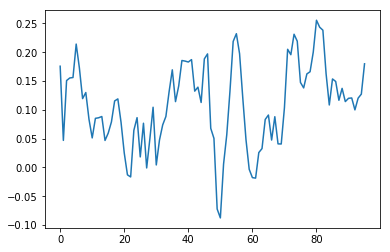

In [81]:
plot_smoothed(pg_train_loss, n=4)

In [39]:
gen_train_errors = []
discr_train_errors = []
info_train_errors = []
llh_train_errors = []
accuracies_in_names = []

In [79]:
for epoch in range(200):
    for _ in range(1):
        for bx, by, respondent in generate_data(data_rows, speakers_list=speakers_list, n_iter=3, max_len=seq_len):
            err = pg_trainer.train_step(bx, respondent, 20)
            gen_train_errors.append(err)
        print("Gen %.5f"%err)
    for _ in range(6):
        for bx, by, respondent in generate_data(data_rows, speakers_list=speakers_list, n_iter=8, max_len=seq_len):
            err, infoloss = conv_discriminator.train_step(bx, by, respondent, 20, sample_c(respondent))
            discr_train_errors.append(err)
            info_train_errors.append(infoloss)
        print("Discr %.5f"%err)


/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


MemoryError: Error allocating 52428800 bytes of device memory (CNMEM_STATUS_OUT_OF_MEMORY).
Apply node that caused the error: GpuContiguous(GpuDimShuffle{0,3,1,2}.0)
Toposort index: 539
Inputs types: [CudaNdarrayType(float32, 4D)]
Inputs shapes: [(32, 1024, 20, 20)]
Inputs strides: [(409600, 1, 20480, 1024)]
Inputs values: ['not shown']
Inputs type_num: ['']
Outputs clients: [[GpuDnnConv{algo='small', inplace=True}(GpuContiguous.0, GpuContiguous.0, GpuAllocEmpty.0, GpuDnnConvDesc{border_mode='valid', subsample=(1, 1), conv_mode='conv', precision='float32'}.0, Constant{1.0}, Constant{0.0})]]

Debugprint of the apply node: 
GpuContiguous [id A] <CudaNdarrayType(float32, 4D)> ''   
 |GpuDimShuffle{0,3,1,2} [id B] <CudaNdarrayType(float32, 4D)> ''   
   |GpuJoin [id C] <CudaNdarrayType(float32, 4D)> ''   
     |TensorConstant{3} [id D] <TensorType(int8, scalar)>
     |GpuReshape{4} [id E] <CudaNdarrayType(float32, 4D)> ''   
     | |GpuAlloc [id F] <CudaNdarrayType(float32, 4D)> ''   
     | | |GpuDimShuffle{0,1,x,2} [id G] <CudaNdarrayType(float32, (False, False, True, False))> ''   
     | | | |GpuReshape{3} [id H] <CudaNdarrayType(float32, 3D)> ''   
     | | |   |GpuAdvancedSubtensor1 [id I] <CudaNdarrayType(float32, matrix)> ''   
     | | |   | |W [id J] <CudaNdarrayType(float32, matrix)>
     | | |   | |Elemwise{Cast{int64}} [id K] <TensorType(int64, vector)> ''   
     | | |   |   |Reshape{1} [id L] <TensorType(int32, vector)> ''   
     | | |   |     |encoder phrase tokens [id M] <TensorType(int32, matrix)>
     | | |   |     |TensorConstant{(1,) of -1} [id N] <TensorType(int64, (True,))>
     | | |   |MakeVector{dtype='int64'} [id O] <TensorType(int64, vector)> ''   
     | | |     |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
     | | |     | |encoder phrase tokens [id M] <TensorType(int32, matrix)>
     | | |     |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
     | | |     | |encoder phrase tokens [id M] <TensorType(int32, matrix)>
     | | |     |Shape_i{1} [id R] <TensorType(int64, scalar)> ''   
     | | |       |W [id J] <CudaNdarrayType(float32, matrix)>
     | | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
     | | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
     | | |TensorConstant{20} [id S] <TensorType(int8, scalar)>
     | | |Shape_i{1} [id R] <TensorType(int64, scalar)> ''   
     | |TensorConstant{[ -1  20  20 512]} [id T] <TensorType(int64, vector)>
     |GpuReshape{4} [id U] <CudaNdarrayType(float32, 4D)> ''   
       |GpuAlloc [id V] <CudaNdarrayType(float32, 4D)> ''   
       | |GpuDimShuffle{0,1,x,2} [id W] <CudaNdarrayType(float32, (False, False, True, False))> ''   
       | | |GpuReshape{3} [id X] <CudaNdarrayType(float32, 3D)> ''   
       | |   |GpuAdvancedSubtensor1 [id Y] <CudaNdarrayType(float32, matrix)> ''   
       | |   | |W [id Z] <CudaNdarrayType(float32, matrix)>
       | |   | |Elemwise{Cast{int64}} [id BA] <TensorType(int64, vector)> ''   
       | |   |   |Reshape{1} [id BB] <TensorType(int32, vector)> ''   
       | |   |     |InplaceDimShuffle{1,0} [id BC] <TensorType(int32, matrix)> ''   
       | |   |     | |Subtensor{int64:int64:int8} [id BD] <TensorType(int32, matrix)> ''   
       | |   |     |   |forall_inplace,gpu,scan_fn&scan_fn}.3 [id BE] <TensorType(int32, matrix)> ''   
       | |   |     |   | |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   | |GpuIncSubtensor{InplaceSet;:int64:} [id BG] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | |GpuAllocEmpty [id BH] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | |Elemwise{Composite{(Switch(LT(i0, i1), (i0 + i2), (i0 - i1)) + i2)}} [id BI] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |Elemwise{Composite{maximum(maximum(((i0 - Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((i1 + i2), (i3 + i2), i4, i5), i4, (i1 + i2), i5), i4), Composite{Switch(LT(i0, i1), i1, i0)}((i1 + i2), i4)), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((i1 + i2), (i3 + i2), i4, i5), i4, (i1 + i2), i5), i4), Composite{Switch(LT(i0, i1), i1, i0)}((i1 + i2), i4))) + i2), i6), maximum(((i0 - Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((i7 + i2), (i8 + i2), i4, i5), i4, (i7 + i2), i5), i4), Composite{Switch(LT(i0, i1), i1, i0)}((i7 + i2), i4)), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((i7 + i2), (i8 + i2), i4, i5), i4, (i7 + i2), i5), i4), Composite{Switch(LT(i0, i1), i1, i0)}((i7 + i2), i4))) + i2), i6))}} [id BJ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   | | | | | |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, (i3 - i4)))}(i0, i1, i2, i3, i4), i1, i5), i1, i6), i5), i7, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, (i3 - i4)))}(i0, i1, i2, i3, i4), i1, i5), i1, i6))}} [id BK] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{le,no_inplace} [id BL] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | |Elemwise{sub,no_inplace} [id BM] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}} [id BN] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{le,no_inplace} [id BO] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i4, i2), i4, i2))}} [id BP] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |Elemwise{lt,no_inplace} [id BQ] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |Elemwise{Identity} [id BR] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   | | | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   | | | | | | | | | | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id BT] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | | |Elemwise{sub,no_inplace} [id BV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id BW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id BX] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | | | | | |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   | | | | | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1)}} [id BZ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id BX] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id BW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | | |   |Elemwise{Identity} [id BR] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |Elemwise{Identity} [id BR] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |Elemwise{Composite{Switch(i0, Switch(LT((i1 + i2), i3), i3, (i1 + i2)), Switch(LT(i4, i2), i4, i2))}} [id BP] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id BT] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{sub,no_inplace} [id BV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5)}} [id CB] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |   |Elemwise{le,no_inplace} [id BO] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | |   |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | |   |TensorConstant{0} [id CC] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | |   |Elemwise{Composite{Switch(LT((i0 + i1), i2), i2, (i0 + i1))}} [id BT] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |   |Elemwise{sub,no_inplace} [id BV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |   |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}} [id BN] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1)}} [id BZ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{add,no_inplace} [id CD] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id BW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1), i4), i1), i5)}} [id CB] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{add,no_inplace} [id BX] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | |Elemwise{sub,no_inplace} [id CE] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |   |Elemwise{add,no_inplace} [id BX] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |   |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | |Elemwise{Composite{(((i0 - Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, maximum((i5 + i6), i2)))}(i1, i2, (i3 - i4), i5, i6, i7, i8), i2, i9), i2, i10), i9), i9, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, maximum((i5 + i6), i2)))}(i1, i2, (i3 - i4), i5, i6, i7, i8), i2, i9), i2, i10))) - i11) // i12)}} [id CG] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, (i3 - i4)))}(i0, i1, i2, i3, i4), i1, i5), i1, i6), i5), i7, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, (i3 - i4)))}(i0, i1, i2, i3, i4), i1, i5), i1, i6))}} [id BK] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{le,no_inplace} [id BL] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | |Elemwise{add,no_inplace} [id CD] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{Composite{Switch(LT(Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i1), i1, Composite{Switch(GE(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, minimum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4))}} [id BN] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{sub,no_inplace} [id BM] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{sub,no_inplace} [id CH] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |TensorConstant{-2} [id CI] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   | | | | | | |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1)}} [id BZ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{add,no_inplace} [id BX] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | |TensorConstant{2} [id CJ] <TensorType(int64, scalar)>
       | |   |     |   | | | | | |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}} [id CK] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{lt,no_inplace} [id CL] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | |Elemwise{Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}} [id CM] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{le,no_inplace} [id CN] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{sub,no_inplace} [id CO] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id CP] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |Elemwise{add,no_inplace} [id CQ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | | |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i6, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5))}} [id CR] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   |Elemwise{le,no_inplace} [id CS] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | |Elemwise{Composite{Switch(i0, Switch(LT(Composite{((i0 + i1) - i2)}(i1, i2, i3), i4), i4, Composite{((i0 + i1) - i2)}(i1, i2, i3)), Switch(LT(i5, i6), i5, i6))}} [id CT] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | |Elemwise{lt,no_inplace} [id BQ] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   | | | | | | | | | | | |   | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id CU] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | | |Elemwise{switch,no_inplace} [id CV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | | | |Elemwise{lt,no_inplace} [id BQ] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |   | | | | |Elemwise{Identity} [id BR] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |   | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1)}} [id CW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | | |Elemwise{switch,no_inplace} [id CV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id CU] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |   | | | |Elemwise{add,no_inplace} [id CX] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | |   |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | |   | | |   |Elemwise{switch,no_inplace} [id CV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |   | | |Elemwise{Identity} [id BR] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | | |Elemwise{sub,no_inplace} [id CY] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | |   |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id CU] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1)}} [id CW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |   |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1)}} [id CW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id CZ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   | |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | |   | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id CU] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   |Elemwise{switch,no_inplace} [id CV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |   |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id CX] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), (i4 - i5), maximum((i4 + i6), i2)))}(i2, i3, (i4 - i5), i5, i6, i7, i8), i3, i7), i3, i9), i7), i3), i3, i1), i3), i10), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), (i4 - i5), maximum((i4 + i6), i2)))}(i2, i3, (i4 - i5), i5, i6, i7, i8), i3, i7), i3, i9), i7), i3), i3, i1), i3), i10)}} [id DA] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |   |Elemwise{add,no_inplace} [id CQ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |   |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i6, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5))}} [id CR] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |   |Elemwise{le,no_inplace} [id CS] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | |   |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |   |Elemwise{add,no_inplace} [id CZ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |   |Elemwise{Composite{Switch(i0, Switch(LT(Composite{((i0 + i1) - i2)}(i1, i2, i3), i4), i4, Composite{((i0 + i1) - i2)}(i1, i2, i3)), Switch(LT(i5, i6), i5, i6))}} [id CT] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |   |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | |   |Elemwise{switch,no_inplace} [id CV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |   |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}((i0 - i1), i2, i3), i2), i1)}} [id CW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |   |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |   |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id CP] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id CP] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{switch,no_inplace} [id CV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |TensorConstant{0} [id CC] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | |Elemwise{Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}} [id CM] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{add,no_inplace} [id BX] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | |Elemwise{sub,no_inplace} [id CE] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |Elemwise{Composite{(((i0 - Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i1, i2, i3), i4, i5), i3), i3, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i1, i2, i3), i4, i5))) - i6) // i7)}} [id DB] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |   |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}} [id CK] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |   |Elemwise{lt,no_inplace} [id DC] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | |   | |Elemwise{Composite{Switch(i0, i1, Switch(AND(LT((i2 + i3), i1), GT(i4, i1)), i5, minimum((i2 + i3), i6)))}} [id DD] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |   | | |Elemwise{le,no_inplace} [id CN] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | |   | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | |   | | |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | |   | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), (i4 - i5), maximum((i4 + i6), i2)))}(i2, i3, (i4 - i5), i5, i6, i7, i8), i3, i7), i3, i9), i7), i3), i3, i1), i3), i10), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), (i4 - i5), maximum((i4 + i6), i2)))}(i2, i3, (i4 - i5), i5, i6, i7, i8), i3, i7), i3, i9), i7), i3), i3, i1), i3), i10)}} [id DA] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |   | | |Elemwise{sub,no_inplace} [id CO] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |   | | |Elemwise{sub,no_inplace} [id CH] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |   | | |Elemwise{switch,no_inplace} [id CV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |   | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | |   |Elemwise{Composite{Switch(i0, i1, Switch(AND(LT((i2 + i3), i1), GT(i4, i1)), i5, minimum((i2 + i3), i6)))}} [id DD] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |   |Elemwise{add,no_inplace} [id BX] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |   |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | |   |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | |   |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | |   |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | |TensorConstant{1024} [id DE] <TensorType(int64, scalar)>
       | |   |     |   | | |GpuFromHost [id DF] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | |Rebroadcast{0} [id DG] <TensorType(float32, 3D)> ''   
       | |   |     |   | | |   |Alloc [id DH] <TensorType(float32, (True, False, False))> ''   
       | |   |     |   | | |     |TensorConstant{0.0} [id DI] <TensorType(float32, scalar)>
       | |   |     |   | | |     |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | |     |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | |     |TensorConstant{1024} [id DJ] <TensorType(int16, scalar)>
       | |   |     |   | | |Constant{1} [id DK] <int64>
       | |   |     |   | |GpuIncSubtensor{InplaceSet;:int64:} [id DL] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | |GpuAllocEmpty [id DM] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | |Elemwise{Composite{(Switch(LT(maximum(i0, i1), i2), (maximum(i0, i1) + i3), (maximum(i0, i1) - i2)) + i3)}} [id DN] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |Elemwise{Composite{((i0 - Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), Composite{((((i0 - Switch(GE(i1, i2), i2, i1)) - i3) // i4) + i4)}(Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i8, i9, i3), i4, i5), i3, i6, i7), i4, i6), i4, (Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), i6), i4), Composite{Switch(LT(i0, i1), i1, i0)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), i4)), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), Composite{((((i0 - Switch(GE(i1, i2), i2, i1)) - i3) // i4) + i4)}(Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i8, i9, i3), i4, i5), i3, i6, i7), i4, i6), i4, (Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), i6), i4), Composite{Switch(LT(i0, i1), i1, i0)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), i4))) + i7)}} [id DO] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   | | | | | |Elemwise{lt,no_inplace} [id CL] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | |Elemwise{Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}} [id CM] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |Elemwise{add,no_inplace} [id DP] <TensorType(int32, scalar)> ''   
       | |   |     |   | | | | | | |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   | | | | | | |TensorConstant{1} [id DQ] <TensorType(int32, scalar)>
       | |   |     |   | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | |Elemwise{lt,no_inplace} [id DC] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | |Elemwise{Composite{Switch(i0, i1, Switch(AND(LT((i2 + i3), i1), GT(i4, i1)), i5, minimum((i2 + i3), i6)))}} [id DD] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |TensorConstant{2} [id CJ] <TensorType(int64, scalar)>
       | |   |     |   | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | |TensorConstant{1024} [id DE] <TensorType(int64, scalar)>
       | |   |     |   | | |GpuFromHost [id DF] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | |Constant{1} [id DK] <int64>
       | |   |     |   | |IncSubtensor{InplaceSet;:int64:} [id DR] <TensorType(int32, matrix)> ''   
       | |   |     |   | | |AllocEmpty{dtype='int32'} [id DS] <TensorType(int32, matrix)> ''   
       | |   |     |   | | | |Elemwise{Composite{(Switch(LT(maximum(i0, i1), i2), (maximum(i0, i1) + i3), (maximum(i0, i1) - i2)) + i3)}} [id DN] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | |Rebroadcast{0} [id DT] <TensorType(int32, matrix)> ''   
       | |   |     |   | | | |Alloc [id DU] <TensorType(int32, row)> ''   
       | |   |     |   | | |   |TensorConstant{(1, 1) of 36069} [id DV] <TensorType(int32, (True, True))>
       | |   |     |   | | |   |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | |   |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | |Constant{1} [id DK] <int64>
       | |   |     |   | |IncSubtensor{InplaceSet;:int64:} [id DW] <TensorType(int32, matrix)> ''   
       | |   |     |   | | |AllocEmpty{dtype='int32'} [id DX] <TensorType(int32, matrix)> ''   
       | |   |     |   | | | |Elemwise{Composite{(Switch(LT(maximum(i0, i1), i2), (maximum(i0, i1) + i3), (maximum(i0, i1) - i2)) + i3)}} [id DY] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | |Elemwise{Composite{((i0 - Switch(LT(i1, i2), i1, i2)) + i1)}} [id DZ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | |Elemwise{add,no_inplace} [id DP] <TensorType(int32, scalar)> ''   
       | |   |     |   | | | | |TensorConstant{2} [id CJ] <TensorType(int64, scalar)>
       | |   |     |   | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | |Rebroadcast{0} [id DT] <TensorType(int32, matrix)> ''   
       | |   |     |   | | |Constant{1} [id DK] <int64>
       | |   |     |   | |GpuIncSubtensor{InplaceSet;:int64:} [id EA] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | |GpuAllocEmpty [id EB] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | |Elemwise{Composite{(Switch(LT(maximum(i0, i1), i2), (maximum(i0, i1) + i3), (maximum(i0, i1) - i2)) + i3)}} [id DY] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | |TensorConstant{36071} [id EC] <TensorType(int64, scalar)>
       | |   |     |   | | |GpuFromHost [id ED] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | |Rebroadcast{0} [id EE] <TensorType(float32, 3D)> ''   
       | |   |     |   | | |   |Alloc [id EF] <TensorType(float32, (True, False, False))> ''   
       | |   |     |   | | |     |TensorConstant{0.0} [id DI] <TensorType(float32, scalar)>
       | |   |     |   | | |     |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | |     |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | |     |TensorConstant{36071} [id EG] <TensorType(int32, scalar)>
       | |   |     |   | | |Constant{1} [id DK] <int64>
       | |   |     |   | |GpuIncSubtensor{InplaceSet;:int64:} [id EH] <CudaNdarrayType(float32, (True, False, False))> ''   
       | |   |     |   | | |GpuAllocEmpty [id EI] <CudaNdarrayType(float32, (True, False, False))> ''   
       | |   |     |   | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | |TensorConstant{1024} [id DE] <TensorType(int64, scalar)>
       | |   |     |   | | |GpuFromHost [id EJ] <CudaNdarrayType(float32, (True, False, False))> ''   
       | |   |     |   | | | |Alloc [id DH] <TensorType(float32, (True, False, False))> ''   
       | |   |     |   | | |Constant{1} [id DK] <int64>
       | |   |     |   | |DeepCopyOp [id EK] <CudaNdarrayType(float32, (True, False, False))> ''   
       | |   |     |   | | |GpuIncSubtensor{InplaceSet;:int64:} [id EH] <CudaNdarrayType(float32, (True, False, False))> ''   
       | |   |     |   | |IncSubtensor{InplaceSet;:int64:} [id EL] <TensorType(int32, row)> ''   
       | |   |     |   | | |AllocEmpty{dtype='int32'} [id EM] <TensorType(int32, row)> ''   
       | |   |     |   | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | |TensorConstant{(1, 1) of 36069} [id DV] <TensorType(int32, (True, True))>
       | |   |     |   | | |Constant{1} [id DK] <int64>
       | |   |     |   | |DeepCopyOp [id EN] <TensorType(int32, matrix)> ''   
       | |   |     |   | | |IncSubtensor{InplaceSet;:int64:} [id DW] <TensorType(int32, matrix)> ''   
       | |   |     |   | |<RandomStateType> [id EO] <RandomStateType>
       | |   |     |   | |context embedding.W [id EP] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |decoder intermediate.W [id EQ] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |decoder next word probas.W [id ER] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |GpuDot22 [id ES] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | |GpuAdvancedSubtensor1 [id ET] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | | |persona_based.emb.W [id EU] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | |Elemwise{Cast{int64}} [id EV] <TensorType(int64, vector)> ''   
       | |   |     |   | | |   |personality idxs [id EW] <TensorType(int32, vector)>
       | |   |     |   | | |GpuJoin [id EX] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | |   |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | |   |decoder_lstm.W_persona_based.each_tick_to_ingate [id EY] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |   |decoder_lstm.W_persona_based.each_tick_to_forgetgate [id EZ] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |   |decoder_lstm.W_persona_based.each_tick_to_cell [id FA] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |   |decoder_lstm.W_persona_based.each_tick_to_outgate [id FB] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |GpuDot22 [id FC] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | |GpuSubtensor{int64} [id FD] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | | |forall_inplace,gpu,scan_fn}.1 [id FE] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | |Elemwise{maximum,no_inplace} [id FF] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |Elemwise{Composite{minimum(maximum(maximum((i0 - i1), (i0 - i1)), ((i2 + i3) - i1)), i4)}} [id FG] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id FH] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |Elemwise{add,no_inplace} [id FI] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}} [id FJ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{lt,no_inplace} [id FK] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | |Elemwise{Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}} [id FL] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |Elemwise{le,no_inplace} [id FM] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |Elemwise{sub,no_inplace} [id FN] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id FO] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |Elemwise{add,no_inplace} [id FP] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | | | | | |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i3, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5))}} [id FQ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   |Elemwise{le,no_inplace} [id FR] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id FS] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   | | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   | | |Elemwise{sub,no_inplace} [id FT] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   | |   |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   | |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id FU] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   | |     |TensorConstant{0} [id CC] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | | | | |   | |     |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | | | | |   |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | | | | |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id FU] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id FV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   | |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | | | | |   | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | | |   |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, maximum((i5 + i6), i2)))}(i2, i3, (i4 - i5), i5, i6, i7, i8), i3, i9), i3, i10), i9), i3), i3, i1), i3), i11), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, maximum((i5 + i6), i2)))}(i2, i3, (i4 - i5), i5, i6, i7, i8), i3, i9), i3, i10), i9), i3), i3, i1), i3), i11)}} [id FW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id FP] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5), i4), i3, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, i3))}(i0, i1, i2, i3), i1, i4), i1, i5))}} [id FQ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |Elemwise{le,no_inplace} [id FR] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | | |   |Elemwise{add,no_inplace} [id FV] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id FS] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |Elemwise{sub,no_inplace} [id FX] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   | |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | | |   | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | | |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id FU] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |   |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | | |   |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id FO] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id FO] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |TensorConstant{0} [id CC] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |Elemwise{Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}} [id FL] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{add,no_inplace} [id FY] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | |Elemwise{Composite{Switch(i0, (i1 + i2), i1)}} [id FZ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |Elemwise{lt,no_inplace} [id GA] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{Composite{Switch(LT((i0 - i1), i2), i3, Switch(GE((i0 - i1), i4), (i5 + i0), Switch(LE(i4, i2), (i5 + i0), i0)))}} [id GB] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id GC] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | |Elemwise{add,no_inplace} [id FY] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |Elemwise{sub,no_inplace} [id GD] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | |TensorConstant{-2} [id CI] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{sub,no_inplace} [id GE] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | |Elemwise{add,no_inplace} [id FY] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id GC] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |TensorConstant{2} [id CJ] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | |Elemwise{Composite{Switch(LT((i0 - i1), i2), i3, Switch(GE((i0 - i1), i4), (i5 + i0), Switch(LE(i4, i2), (i5 + i0), i0)))}} [id GB] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |Elemwise{add,no_inplace} [id FY] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | |GpuSubtensor{int64:int64:int8} [id GF] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | | |GpuElemwise{add,no_inplace} [id GG] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | | | |GpuReshape{3} [id GH] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | | | | |GpuDot22 [id GI] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | | | | | | | |GpuReshape{2} [id GJ] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | | | | | | | | |GpuDimShuffle{1,0,2} [id GK] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | | | | | | | |GpuReshape{3} [id GL] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | | | | | | |   |GpuAdvancedSubtensor1 [id GM] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | | | | | | | | |   | |context embedding.W [id EP] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | | | | | | | |   | |Elemwise{Cast{int64}} [id K] <TensorType(int64, vector)> ''   
       | |   |     |   | | | | | | | | | |   |MakeVector{dtype='int64'} [id GN] <TensorType(int64, vector)> ''   
       | |   |     |   | | | | | | | | | |     |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |     |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |     |Shape_i{1} [id GO] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |       |context embedding.W [id EP] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | | | | | | | |MakeVector{dtype='int64'} [id GP] <TensorType(int64, vector)> ''   
       | |   |     |   | | | | | | | | |   |Elemwise{mul,no_inplace} [id GQ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |   | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |   | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |   |Shape_i{1} [id GO] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |GpuJoin [id GR] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | | | | | | |   |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | |   |encoder_lstm.W_in_to_ingate [id GS] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | | | | | |   |encoder_lstm.W_in_to_forgetgate [id GT] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | | | | | |   |encoder_lstm.W_in_to_cell [id GU] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | | | | | |   |encoder_lstm.W_in_to_outgate [id GV] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | | | | | |MakeVector{dtype='int64'} [id GW] <TensorType(int64, vector)> ''   
       | |   |     |   | | | | | | |   |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |   |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |   |Elemwise{add,no_inplace} [id GX] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |     |Shape_i{1} [id GY] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |     | |encoder_lstm.W_in_to_ingate [id GS] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | | | | |     |Shape_i{1} [id GZ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |     | |encoder_lstm.W_in_to_forgetgate [id GT] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | | | | |     |Shape_i{1} [id HA] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |     | |encoder_lstm.W_in_to_cell [id GU] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | | | | |     |Shape_i{1} [id HB] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |       |encoder_lstm.W_in_to_outgate [id GV] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | | | | |GpuDimShuffle{x,x,0} [id HC] <CudaNdarrayType(float32, (True, True, False))> ''   
       | |   |     |   | | | | | |   |GpuJoin [id HD] <CudaNdarrayType(float32, vector)> ''   
       | |   |     |   | | | | | |     |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | |     |encoder_lstm.b_ingate [id HE] <CudaNdarrayType(float32, vector)>
       | |   |     |   | | | | | |     |encoder_lstm.b_forgetgate [id HF] <CudaNdarrayType(float32, vector)>
       | |   |     |   | | | | | |     |encoder_lstm.b_cell [id HG] <CudaNdarrayType(float32, vector)>
       | |   |     |   | | | | | |     |encoder_lstm.b_outgate [id HH] <CudaNdarrayType(float32, vector)>
       | |   |     |   | | | | | |ScalarFromTensor [id HI] <int64> ''   
       | |   |     |   | | | | | | |Elemwise{Composite{Switch(LE(i0, i1), i1, i2)}} [id HJ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |   |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |   |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | |   |TensorConstant{0} [id CC] <TensorType(int64, scalar)>
       | |   |     |   | | | | | |ScalarFromTensor [id HK] <int64> ''   
       | |   |     |   | | | | | | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |Constant{1} [id HL] <int8>
       | |   |     |   | | | | |Subtensor{int64:int64:int8} [id HM] <TensorType(bool, (False, False, True))> ''   
       | |   |     |   | | | | | |Elemwise{neq,no_inplace} [id HN] <TensorType(bool, (False, False, True))> ''   
       | |   |     |   | | | | | | |InplaceDimShuffle{1,0,x} [id HO] <TensorType(int32, (False, False, True))> ''   
       | |   |     |   | | | | | | | |encoder phrase tokens [id M] <TensorType(int32, matrix)>
       | |   |     |   | | | | | | |TensorConstant{(1, 1, 1) of 36070} [id HP] <TensorType(int32, (True, True, True))>
       | |   |     |   | | | | | |ScalarFromTensor [id HI] <int64> ''   
       | |   |     |   | | | | | |ScalarFromTensor [id HK] <int64> ''   
       | |   |     |   | | | | | |Constant{1} [id HL] <int8>
       | |   |     |   | | | | |GpuIncSubtensor{InplaceSet;:int64:} [id HQ] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | | |GpuAllocEmpty [id HR] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | | | |Elemwise{Composite{(Switch(LT(maximum(i0, i1), i2), (maximum(i0, i1) + i3), (maximum(i0, i1) - i2)) + i3)}} [id HS] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |Elemwise{Composite{((i0 - Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}(i1, (i2 + i3), i4, i5), i4, i1, i5), i4), i6), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}(i1, (i2 + i3), i4, i5), i4, i1, i5), i4), i6)) + i3)}} [id HT] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{maximum,no_inplace} [id FF] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{add,no_inplace} [id FI] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{Composite{(((i0 - Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i1, i2, i3), i4, i5), i3), i3, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i1, i2, i3), i4, i5))) - i6) // i7)}} [id HU] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}} [id FJ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{lt,no_inplace} [id HV] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | |Elemwise{Composite{Switch(i0, i1, Switch(i2, i3, i4))}} [id HW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |Elemwise{le,no_inplace} [id FM] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | |Elemwise{Composite{AND(LT(i0, i1), GT(i2, i1))}} [id HX] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |Elemwise{add,no_inplace} [id HY] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | | |TensorConstant{-1} [id BU] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | | | | | | |Elemwise{Composite{Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, maximum((i5 + i6), i2)))}(i2, i3, (i4 - i5), i5, i6, i7, i8), i3, i9), i3, i10), i9), i3), i3, i1), i3), i11), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{(i0 - Switch(LT(i1, i2), i2, i1))}(i0, Composite{(i0 - Switch(GE(i1, i2), i2, i1))}(i1, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, maximum((i5 + i6), i2)))}(i2, i3, (i4 - i5), i5, i6, i7, i8), i3, i9), i3, i10), i9), i3), i3, i1), i3), i11)}} [id FW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | | | | |Elemwise{sub,no_inplace} [id FN] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |Elemwise{sub,no_inplace} [id GD] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id HZ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | |   |Elemwise{add,no_inplace} [id HY] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | |   |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |Elemwise{Composite{Switch(i0, i1, Switch(i2, i3, i4))}} [id HW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{add,no_inplace} [id FY] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | |Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}} [id FH] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |TensorConstant{2} [id CJ] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Shape_i{1} [id IA] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |   |encoder_lstm.cell_init [id IB] <CudaNdarrayType(float32, row)>
       | |   |     |   | | | | | |Rebroadcast{0} [id IC] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | | | |GpuDimShuffle{x,0,1} [id ID] <CudaNdarrayType(float32, (True, False, False))> ''   
       | |   |     |   | | | | | |   |GpuGer{inplace} [id IE] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | | | | |     |GpuAlloc{memset_0=True} [id IF] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | | | | |     | |CudaNdarrayConstant{0.0} [id IG] <CudaNdarrayType(float32, scalar)>
       | |   |     |   | | | | | |     | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |     | |Shape_i{1} [id IA] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |     |TensorConstant{1.0} [id IH] <TensorType(float32, scalar)>
       | |   |     |   | | | | | |     |GpuDimShuffle{0} [id II] <CudaNdarrayType(float32, vector)> ''   
       | |   |     |   | | | | | |     | |GpuAlloc [id IJ] <CudaNdarrayType(float32, col)> ''   
       | |   |     |   | | | | | |     |   |CudaNdarrayConstant{1.0} [id IK] <CudaNdarrayType(float32, scalar)>
       | |   |     |   | | | | | |     |   |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |     |   |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | |     |GpuDimShuffle{1} [id IL] <CudaNdarrayType(float32, vector)> ''   
       | |   |     |   | | | | | |       |encoder_lstm.cell_init [id IB] <CudaNdarrayType(float32, row)>
       | |   |     |   | | | | | |Constant{1} [id DK] <int64>
       | |   |     |   | | | | |GpuIncSubtensor{InplaceSet;:int64:} [id IM] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | | |GpuAllocEmpty [id IN] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | | | |Elemwise{Composite{(Switch(LT(i0, i1), (i0 + i2), (i0 - i1)) + i2)}} [id IO] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | |Elemwise{Composite{maximum(maximum(((i0 - Switch(i1, (i2 + i3), i2)) + i4), i5), maximum(((i0 - Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), Composite{((((i0 - Switch(GE(i1, i2), i2, i1)) - i3) // i4) + i4)}(Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i11, i12, i3), i8, i9), i3, i13, i4), i8, i13), i8, (Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i13), i8), Composite{Switch(LT(i0, i1), i1, i0)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i8)), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), Composite{((((i0 - Switch(GE(i1, i2), i2, i1)) - i3) // i4) + i4)}(Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i11, i12, i3), i8, i9), i3, i13, i4), i8, i13), i8, (Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i13), i8), Composite{Switch(LT(i0, i1), i1, i0)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i8))) + i4), i5))}} [id IP] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{maximum,no_inplace} [id FF] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{lt,no_inplace} [id GA] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{Composite{Switch(LT((i0 - i1), i2), i3, Switch(GE((i0 - i1), i4), (i5 + i0), Switch(LE(i4, i2), (i5 + i0), i0)))}} [id GB] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{add,no_inplace} [id IQ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Shape_i{1} [id Q] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | |TensorConstant{2} [id CJ] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | | | |Elemwise{lt,no_inplace} [id FK] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}} [id FL] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | |TensorConstant{-1} [id CA] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | |Elemwise{sub,no_inplace} [id IR] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |Elemwise{add,no_inplace} [id IQ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | | |Elemwise{lt,no_inplace} [id HV] <TensorType(bool, scalar)> ''   
       | |   |     |   | | | | | | | | |Elemwise{Composite{Switch(i0, i1, Switch(i2, i3, i4))}} [id HW] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | | | | | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   | | | | | | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | | |Shape_i{1} [id IS] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |   |encoder_lstm.hid_init [id IT] <CudaNdarrayType(float32, row)>
       | |   |     |   | | | | | |Rebroadcast{0} [id IU] <CudaNdarrayType(float32, 3D)> ''   
       | |   |     |   | | | | | | |GpuDimShuffle{x,0,1} [id IV] <CudaNdarrayType(float32, (True, False, False))> ''   
       | |   |     |   | | | | | |   |GpuGer{inplace} [id IW] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | | | | |     |GpuAlloc{memset_0=True} [id IX] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | | | | |     | |CudaNdarrayConstant{0.0} [id IG] <CudaNdarrayType(float32, scalar)>
       | |   |     |   | | | | | |     | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |     | |Shape_i{1} [id IS] <TensorType(int64, scalar)> ''   
       | |   |     |   | | | | | |     |TensorConstant{1.0} [id IH] <TensorType(float32, scalar)>
       | |   |     |   | | | | | |     |GpuDimShuffle{0} [id II] <CudaNdarrayType(float32, vector)> ''   
       | |   |     |   | | | | | |     |GpuDimShuffle{1} [id IY] <CudaNdarrayType(float32, vector)> ''   
       | |   |     |   | | | | | |       |encoder_lstm.hid_init [id IT] <CudaNdarrayType(float32, row)>
       | |   |     |   | | | | | |Constant{1} [id DK] <int64>
       | |   |     |   | | | | |GpuJoin [id IZ] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | | |   |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | | |   |encoder_lstm.W_hid_to_ingate [id JA] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | |   |encoder_lstm.W_hid_to_forgetgate [id JB] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | |   |encoder_lstm.W_hid_to_cell [id JC] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | |   |encoder_lstm.W_hid_to_outgate [id JD] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | | |ScalarFromTensor [id JE] <int64> ''   
       | |   |     |   | | |   |Elemwise{Composite{(((i0 - i1) - i2) + i3)}} [id JF] <TensorType(int64, scalar)> ''   
       | |   |     |   | | |     |Elemwise{Composite{Switch(i0, (i1 + i2), i1)}} [id FZ] <TensorType(int64, scalar)> ''   
       | |   |     |   | | |     |Elemwise{maximum,no_inplace} [id JG] <TensorType(int64, scalar)> ''   
       | |   |     |   | | |     | |Elemwise{Composite{minimum(maximum(maximum((i0 - i1), (i0 - i1)), ((i2 + i3) - i1)), i4)}} [id FG] <TensorType(int64, scalar)> ''   
       | |   |     |   | | |     | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | |     |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | |     |Elemwise{Composite{maximum(maximum(((i0 - Switch(i1, (i2 + i3), i2)) + i4), i5), maximum(((i0 - Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), Composite{((((i0 - Switch(GE(i1, i2), i2, i1)) - i3) // i4) + i4)}(Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i11, i12, i3), i8, i9), i3, i13, i4), i8, i13), i8, (Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i13), i8), Composite{Switch(LT(i0, i1), i1, i0)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i8)), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), Composite{((((i0 - Switch(GE(i1, i2), i2, i1)) - i3) // i4) + i4)}(Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i11, i12, i3), i8, i9), i3, i13, i4), i8, i13), i8, (Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i13), i8), Composite{Switch(LT(i0, i1), i1, i0)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i8))) + i4), i5))}} [id IP] <TensorType(int64, scalar)> ''   
       | |   |     |   | | |GpuJoin [id JH] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | |   |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | |   |decoder_lstm.W_encoder_to_ingate [id JI] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |   |decoder_lstm.W_encoder_to_forgetgate [id JJ] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |   |decoder_lstm.W_encoder_to_cell [id JK] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |   |decoder_lstm.W_encoder_to_outgate [id JL] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |GpuJoin [id JM] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | |decoder_lstm.W_emb_to_ingate [id JN] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | |decoder_lstm.W_emb_to_forgetgate [id JO] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | |decoder_lstm.W_emb_to_cell [id JP] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | |decoder_lstm.W_emb_to_outgate [id JQ] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |GpuJoin [id JR] <CudaNdarrayType(float32, matrix)> ''   
       | |   |     |   | | |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   | | |decoder_lstm.W_out_to_ingate [id JS] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | |decoder_lstm.W_out_to_forgetgate [id JT] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | |decoder_lstm.W_out_to_cell [id JU] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | | |decoder_lstm.W_out_to_outgate [id JV] <CudaNdarrayType(float32, matrix)>
       | |   |     |   | |GpuDimShuffle{x,0} [id JW] <CudaNdarrayType(float32, row)> ''   
       | |   |     |   | | |GpuJoin [id JX] <CudaNdarrayType(float32, vector)> ''   
       | |   |     |   | |   |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
       | |   |     |   | |   |decoder_lstm.b_to_ingate [id JY] <CudaNdarrayType(float32, vector)>
       | |   |     |   | |   |decoder_lstm.b_to_forgetgate [id JZ] <CudaNdarrayType(float32, vector)>
       | |   |     |   | |   |decoder_lstm.b_to_cell [id KA] <CudaNdarrayType(float32, vector)>
       | |   |     |   | |   |decoder_lstm.b_to_outgate [id KB] <CudaNdarrayType(float32, vector)>
       | |   |     |   | |GpuDimShuffle{x,x} [id KC] <CudaNdarrayType(float32, (True, True))> ''   
       | |   |     |   | | |GpuFromHost [id KD] <CudaNdarrayType(float32, scalar)> ''   
       | |   |     |   | |   |<TensorType(float32, scalar)> [id KE] <TensorType(float32, scalar)>
       | |   |     |   | |GpuDimShuffle{x,0} [id KF] <CudaNdarrayType(float32, row)> ''   
       | |   |     |   | | |decoder next word probas.b [id KG] <CudaNdarrayType(float32, vector)>
       | |   |     |   | |GpuDimShuffle{x,0} [id KH] <CudaNdarrayType(float32, row)> ''   
       | |   |     |   |   |decoder intermediate.b [id KI] <CudaNdarrayType(float32, vector)>
       | |   |     |   |ScalarFromTensor [id KJ] <int64> ''   
       | |   |     |   | |Elemwise{Composite{(((i0 - i1) - i2) + i3)}} [id KK] <TensorType(int64, scalar)> ''   
       | |   |     |   |   |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id KL] <TensorType(int64, scalar)> ''   
       | |   |     |   |   | |TensorConstant{1} [id BY] <TensorType(int64, scalar)>
       | |   |     |   |   | |Elemwise{add,no_inplace} [id BX] <TensorType(int64, scalar)> ''   
       | |   |     |   |   |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   |   |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   |   |Elemwise{maximum,no_inplace} [id KM] <TensorType(int64, scalar)> ''   
       | |   |     |   |     |Elemwise{Composite{((i0 - Switch(LT(i1, i2), i1, i2)) + i1)}} [id DZ] <TensorType(int64, scalar)> ''   
       | |   |     |   |     |TensorConstant{2} [id KN] <TensorType(int8, scalar)>
       | |   |     |   |ScalarFromTensor [id KO] <int64> ''   
       | |   |     |   | |Elemwise{Composite{(((i0 - i1) - i2) + i3)}} [id KP] <TensorType(int64, scalar)> ''   
       | |   |     |   |   |Elemwise{add,no_inplace} [id BX] <TensorType(int64, scalar)> ''   
       | |   |     |   |   |<TensorType(int32, scalar)> [id BF] <TensorType(int32, scalar)>
       | |   |     |   |   |TensorConstant{1} [id CF] <TensorType(int8, scalar)>
       | |   |     |   |   |Elemwise{maximum,no_inplace} [id KM] <TensorType(int64, scalar)> ''   
       | |   |     |   |Constant{1} [id HL] <int8>
       | |   |     |TensorConstant{(1,) of -1} [id N] <TensorType(int64, (True,))>
       | |   |MakeVector{dtype='int64'} [id KQ] <TensorType(int64, vector)> ''   
       | |     |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |     |Elemwise{sub,no_inplace} [id KR] <TensorType(int64, scalar)> ''   
       | |     | |Elemwise{add,no_inplace} [id BX] <TensorType(int64, scalar)> ''   
       | |     | |Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}} [id KL] <TensorType(int64, scalar)> ''   
       | |     |Shape_i{1} [id KS] <TensorType(int64, scalar)> ''   
       | |       |W [id Z] <CudaNdarrayType(float32, matrix)>
       | |Shape_i{0} [id P] <TensorType(int64, scalar)> ''   
       | |Elemwise{sub,no_inplace} [id KR] <TensorType(int64, scalar)> ''   
       | |TensorConstant{20} [id S] <TensorType(int8, scalar)>
       | |Shape_i{1} [id KS] <TensorType(int64, scalar)> ''   
       |TensorConstant{[ -1  20  20 512]} [id T] <TensorType(int64, vector)>

Inner graphs of the scan ops:

forall_inplace,gpu,scan_fn&scan_fn}.3 [id BE] <TensorType(int32, matrix)> ''   
 >GpuElemwise{Composite{((tanh(i0) * scalar_sigmoid(i1)) + (i2 * scalar_sigmoid(i3)))},no_inplace} [id KT] <CudaNdarrayType(float32, matrix)> ''   
 > |GpuSubtensor{::, int64:int64:} [id KU] <CudaNdarrayType(float32, matrix)> ''   
 > | |GpuElemwise{Add}[(0, 3)] [id KV] <CudaNdarrayType(float32, matrix)> ''   
 > | | |<CudaNdarrayType(float32, row)> [id KW] <CudaNdarrayType(float32, row)> -> [id JW]
 > | | |<CudaNdarrayType(float32, matrix)> [id KX] <CudaNdarrayType(float32, matrix)> -> [id FC]
 > | | |<CudaNdarrayType(float32, matrix)> [id KY] <CudaNdarrayType(float32, matrix)> -> [id ES]
 > | | |GpuGemm{inplace} [id KZ] <CudaNdarrayType(float32, matrix)> ''   
 > | |   |GpuDot22 [id LA] <CudaNdarrayType(float32, matrix)> ''   
 > | |   | |<CudaNdarrayType(float32, matrix)> [id LB] <CudaNdarrayType(float32, matrix)> -> [id DL]
 > | |   | |<CudaNdarrayType(float32, matrix)> [id LC] <CudaNdarrayType(float32, matrix)> -> [id JR]
 > | |   |TensorConstant{1.0} [id LD] <TensorType(float32, scalar)>
 > | |   |GpuAdvancedSubtensor1 [id LE] <CudaNdarrayType(float32, matrix)> ''   
 > | |   | |context embedding.W_copy0[cuda] [id LF] <CudaNdarrayType(float32, matrix)> -> [id EP]
 > | |   | |Elemwise{Cast{int64}} [id LG] <TensorType(int64, vector)> ''   
 > | |   |   |<TensorType(int32, vector)> [id LH] <TensorType(int32, vector)> -> [id DR]
 > | |   |<CudaNdarrayType(float32, matrix)> [id LI] <CudaNdarrayType(float32, matrix)> -> [id JM]
 > | |   |TensorConstant{1.0} [id LD] <TensorType(float32, scalar)>
 > | |Constant{2048} [id LJ] <int64>
 > | |Constant{3072} [id LK] <int64>
 > |GpuSubtensor{::, int64:int64:} [id LL] <CudaNdarrayType(float32, matrix)> ''   
 > | |GpuElemwise{Add}[(0, 3)] [id KV] <CudaNdarrayType(float32, matrix)> ''   
 > | |Constant{0} [id LM] <int64>
 > | |Constant{1024} [id LN] <int64>
 > |<CudaNdarrayType(float32, matrix)> [id LO] <CudaNdarrayType(float32, matrix)> -> [id BG]
 > |GpuSubtensor{::, int64:int64:} [id LP] <CudaNdarrayType(float32, matrix)> ''   
 >   |GpuElemwise{Add}[(0, 3)] [id KV] <CudaNdarrayType(float32, matrix)> ''   
 >   |Constant{1024} [id LN] <int64>
 >   |Constant{2048} [id LJ] <int64>
 >GpuElemwise{Composite{tanh((scalar_sigmoid(i0) * i1))},no_inplace} [id LQ] <CudaNdarrayType(float32, matrix)> ''   
 > |GpuSubtensor{::, int64:int64:} [id LR] <CudaNdarrayType(float32, matrix)> ''   
 > | |GpuElemwise{Add}[(0, 3)] [id KV] <CudaNdarrayType(float32, matrix)> ''   
 > | |Constant{3072} [id LK] <int64>
 > | |Constant{4096} [id LS] <int64>
 > |GpuElemwise{Composite{((tanh(i0) * scalar_sigmoid(i1)) + (i2 * scalar_sigmoid(i3)))},no_inplace} [id KT] <CudaNdarrayType(float32, matrix)> ''   
 >ViewOp [id LT] <TensorType(int32, vector)> ''   
 > |Sum{axis=[1], acc_dtype=int64} [id LU] <TensorType(int32, vector)> ''   
 >   |Elemwise{gt,no_inplace} [id LV] <TensorType(bool, matrix)> ''   
 >     |RandomFunction{uniform}.1 [id LW] <TensorType(float32, col)> ''   
 >     | |<RandomStateType> [id LX] <RandomStateType> -> [id EO]
 >     | |MakeVector{dtype='int64'} [id LY] <TensorType(int64, vector)> ''   
 >     | | |Shape_i{0} [id LZ] <TensorType(int64, scalar)> ''   
 >     | | | |<CudaNdarrayType(float32, matrix)> [id LB] <CudaNdarrayType(float32, matrix)> -> [id DL]
 >     | | |TensorConstant{1} [id MA] <TensorType(int64, scalar)>
 >     | |TensorConstant{0.0} [id MB] <TensorType(float32, scalar)>
 >     | |TensorConstant{1.0} [id LD] <TensorType(float32, scalar)>
 >     |HostFromGpu [id MC] <TensorType(float32, matrix)> ''   
 >       |GpuSubtensor{::, :int64:} [id MD] <CudaNdarrayType(float32, matrix)> ''   
 >         |GpuCumsum{1} [id ME] <CudaNdarrayType(float32, matrix)> ''   
 >         | |GpuDimShuffle{0,1} [id MF] <CudaNdarrayType(float32, matrix)> ''   
 >         |   |GpuDnnSoftmax{tensor_format='bc01', mode='channel', algo='accurate'} [id MG] <CudaNdarrayType(float32, (False, False, True, True))> ''   
 >         |     |GpuContiguous [id MH] <CudaNdarrayType(float32, (False, False, True, True))> ''   
 >         |       |GpuDimShuffle{0,1,x,x} [id MI] <CudaNdarrayType(float32, (False, False, True, True))> ''   
 >         |         |GpuElemwise{Composite{((i0 + i1) / i2)}}[(0, 0)] [id MJ] <CudaNdarrayType(float32, matrix)> ''   
 >         |           |GpuDot22 [id MK] <CudaNdarrayType(float32, matrix)> ''   
 >         |           | |GpuElemwise{Composite{tanh((i0 + i1))}}[(0, 0)] [id ML] <CudaNdarrayType(float32, matrix)> ''   
 >         |           | | |GpuDot22 [id MM] <CudaNdarrayType(float32, matrix)> ''   
 >         |           | | | |GpuElemwise{Composite{tanh((scalar_sigmoid(i0) * i1))},no_inplace} [id LQ] <CudaNdarrayType(float32, matrix)> ''   
 >         |           | | | |decoder intermediate.W_copy0[cuda] [id MN] <CudaNdarrayType(float32, matrix)> -> [id EQ]
 >         |           | | |<CudaNdarrayType(float32, row)> [id MO] <CudaNdarrayType(float32, row)> -> [id KH]
 >         |           | |decoder next word probas.W_copy0[cuda] [id MP] <CudaNdarrayType(float32, matrix)> -> [id ER]
 >         |           |<CudaNdarrayType(float32, row)> [id MQ] <CudaNdarrayType(float32, row)> -> [id KF]
 >         |           |<CudaNdarrayType(float32, (True, True))> [id MR] <CudaNdarrayType(float32, (True, True))> -> [id KC]
 >         |Constant{-1} [id MS] <int64>
 >Sum{axis=[1], acc_dtype=int64} [id LU] <TensorType(int32, vector)> ''   
 >GpuDimShuffle{0,1} [id MF] <CudaNdarrayType(float32, matrix)> ''   
 >GpuElemwise{Composite{((tanh(i0) * scalar_sigmoid(i1)) + (i2 * scalar_sigmoid(i3)))},no_inplace} [id MT] <CudaNdarrayType(float32, matrix)> ''   
 > |GpuSubtensor{::, int64:int64:} [id MU] <CudaNdarrayType(float32, matrix)> ''   
 > | |GpuElemwise{Add}[(0, 3)] [id MV] <CudaNdarrayType(float32, matrix)> ''   
 > | | |<CudaNdarrayType(float32, row)> [id KW] <CudaNdarrayType(float32, row)> -> [id JW]
 > | | |<CudaNdarrayType(float32, matrix)> [id KX] <CudaNdarrayType(float32, matrix)> -> [id FC]
 > | | |<CudaNdarrayType(float32, matrix)> [id KY] <CudaNdarrayType(float32, matrix)> -> [id ES]
 > | | |GpuGemm{inplace} [id MW] <CudaNdarrayType(float32, matrix)> ''   
 > | |   |GpuDot22 [id MX] <CudaNdarrayType(float32, matrix)> ''   
 > | |   | |<CudaNdarrayType(float32, matrix)> [id MY] <CudaNdarrayType(float32, matrix)> -> [id EK]
 > | |   | |<CudaNdarrayType(float32, matrix)> [id LC] <CudaNdarrayType(float32, matrix)> -> [id JR]
 > | |   |TensorConstant{1.0} [id LD] <TensorType(float32, scalar)>
 > | |   |GpuAdvancedSubtensor1 [id MZ] <CudaNdarrayType(float32, matrix)> ''   
 > | |   | |context embedding.W_copy0[cuda] [id LF] <CudaNdarrayType(float32, matrix)> -> [id EP]
 > | |   | |Elemwise{Cast{int64}} [id NA] <TensorType(int64, vector)> ''   
 > | |   |   |<TensorType(int32, vector)> [id NB] <TensorType(int32, vector)> -> [id EL]
 > | |   |<CudaNdarrayType(float32, matrix)> [id LI] <CudaNdarrayType(float32, matrix)> -> [id JM]
 > | |   |TensorConstant{1.0} [id LD] <TensorType(float32, scalar)>
 > | |Constant{2048} [id LJ] <int64>
 > | |Constant{3072} [id LK] <int64>
 > |GpuSubtensor{::, int64:int64:} [id NC] <CudaNdarrayType(float32, matrix)> ''   
 > | |GpuElemwise{Add}[(0, 3)] [id MV] <CudaNdarrayType(float32, matrix)> ''   
 > | |Constant{0} [id LM] <int64>
 > | |Constant{1024} [id LN] <int64>
 > |<CudaNdarrayType(float32, matrix)> [id ND] <CudaNdarrayType(float32, matrix)> -> [id EH]
 > |GpuSubtensor{::, int64:int64:} [id NE] <CudaNdarrayType(float32, matrix)> ''   
 >   |GpuElemwise{Add}[(0, 3)] [id MV] <CudaNdarrayType(float32, matrix)> ''   
 >   |Constant{1024} [id LN] <int64>
 >   |Constant{2048} [id LJ] <int64>
 >GpuElemwise{Composite{tanh((scalar_sigmoid(i0) * i1))},no_inplace} [id NF] <CudaNdarrayType(float32, matrix)> ''   
 > |GpuSubtensor{::, int64:int64:} [id NG] <CudaNdarrayType(float32, matrix)> ''   
 > | |GpuElemwise{Add}[(0, 3)] [id MV] <CudaNdarrayType(float32, matrix)> ''   
 > | |Constant{3072} [id LK] <int64>
 > | |Constant{4096} [id LS] <int64>
 > |GpuElemwise{Composite{((tanh(i0) * scalar_sigmoid(i1)) + (i2 * scalar_sigmoid(i3)))},no_inplace} [id MT] <CudaNdarrayType(float32, matrix)> ''   
 >ViewOp [id NH] <TensorType(int32, vector)> ''   
 > |Elemwise{Cast{int32}} [id NI] <TensorType(int32, vector)> ''   
 >   |Argmax [id NJ] <TensorType(int64, vector)> 'argmax'   
 >Elemwise{Cast{int32}} [id NI] <TensorType(int32, vector)> ''   
 >RandomFunction{uniform}.0 [id LW] <RandomStateType> ''   

forall_inplace,gpu,scan_fn}.1 [id FE] <CudaNdarrayType(float32, 3D)> ''   
 >GpuElemwise{Switch,no_inplace} [id NK] <CudaNdarrayType(float32, matrix)> ''   
 > |GpuFromHost [id NL] <CudaNdarrayType(float32, col)> ''   
 > | |Elemwise{Cast{float32}} [id NM] <TensorType(float32, col)> ''   
 > |   |<TensorType(bool, col)> [id NN] <TensorType(bool, col)> -> [id HM]
 > |GpuElemwise{Composite{((scalar_sigmoid(i0) * i1) + (scalar_sigmoid(i2) * tanh(i3)))},no_inplace} [id NO] <CudaNdarrayType(float32, matrix)> ''   
 > | |GpuSubtensor{::, int64:int64:} [id NP] <CudaNdarrayType(float32, matrix)> ''   
 > | | |GpuGemm{no_inplace} [id NQ] <CudaNdarrayType(float32, matrix)> ''   
 > | | | |<CudaNdarrayType(float32, matrix)> [id NR] <CudaNdarrayType(float32, matrix)> -> [id GF]
 > | | | |TensorConstant{1.0} [id NS] <TensorType(float32, scalar)>
 > | | | |<CudaNdarrayType(float32, matrix)> [id NT] <CudaNdarrayType(float32, matrix)> -> [id IM]
 > | | | |<CudaNdarrayType(float32, matrix)> [id NU] <CudaNdarrayType(float32, matrix)> -> [id IZ]
 > | | | |TensorConstant{1.0} [id NS] <TensorType(float32, scalar)>
 > | | |Constant{1024} [id NV] <int64>
 > | | |Constant{2048} [id NW] <int64>
 > | |<CudaNdarrayType(float32, matrix)> [id NX] <CudaNdarrayType(float32, matrix)> -> [id HQ]
 > | |GpuSubtensor{::, int64:int64:} [id NY] <CudaNdarrayType(float32, matrix)> ''   
 > | | |GpuGemm{no_inplace} [id NQ] <CudaNdarrayType(float32, matrix)> ''   
 > | | |Constant{0} [id NZ] <int64>
 > | | |Constant{1024} [id NV] <int64>
 > | |GpuSubtensor{::, int64:int64:} [id OA] <CudaNdarrayType(float32, matrix)> ''   
 > |   |GpuGemm{no_inplace} [id NQ] <CudaNdarrayType(float32, matrix)> ''   
 > |   |Constant{2048} [id NW] <int64>
 > |   |Constant{3072} [id OB] <int64>
 > |<CudaNdarrayType(float32, matrix)> [id NX] <CudaNdarrayType(float32, matrix)> -> [id HQ]
 >GpuElemwise{Composite{Switch(i0, tanh((i1 * scalar_sigmoid(i2))), i3)},no_inplace} [id OC] <CudaNdarrayType(float32, matrix)> ''   
 > |GpuFromHost [id NL] <CudaNdarrayType(float32, col)> ''   
 > |GpuElemwise{Composite{((scalar_sigmoid(i0) * i1) + (scalar_sigmoid(i2) * tanh(i3)))},no_inplace} [id NO] <CudaNdarrayType(float32, matrix)> ''   
 > |GpuSubtensor{::, int64:int64:} [id OD] <CudaNdarrayType(float32, matrix)> ''   
 > | |GpuGemm{no_inplace} [id NQ] <CudaNdarrayType(float32, matrix)> ''   
 > | |Constant{3072} [id OB] <int64>
 > | |Constant{4096} [id OE] <int64>
 > |<CudaNdarrayType(float32, matrix)> [id NT] <CudaNdarrayType(float32, matrix)> -> [id IM]

Storage map footprint:
 - GpuAlloc{memset_0=True}.0, Shape: (2, 36071, 512), ElemSize: 4 Byte(s), TotalSize: 147746816 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.15, Shape: (2, 36071, 512), ElemSize: 4 Byte(s), TotalSize: 147746816 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.4, Shape: (21, 32, 36071), ElemSize: 4 Byte(s), TotalSize: 96958848 Byte(s)
 - GpuSubtensor{::int64}.0, Shape: (21, 32, 36071), ElemSize: 4 Byte(s), TotalSize: 96958848 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.33, Shape: (20, 32, 36071), ElemSize: 4 Byte(s), TotalSize: 92341760 Byte(s)
 - GpuElemwise{maximum,no_inplace}.0, Shape: (32, 20, 36071), ElemSize: 4 Byte(s), TotalSize: 92341760 Byte(s)
 - GpuSubtensor{int64:int64:int8}.0, Shape: (20, 32, 36071), ElemSize: 4 Byte(s), TotalSize: 92341760 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (20, 32, 36071), ElemSize: 4 Byte(s), TotalSize: 92341760 Byte(s)
 - context embedding.W, Shared Input, Shape: (36071, 512), ElemSize: 4 Byte(s), TotalSize: 73873408 Byte(s)
 - W, Shared Input, Shape: (36071, 512), ElemSize: 4 Byte(s), TotalSize: 73873408 Byte(s)
 - W, Shared Input, Shape: (36071, 512), ElemSize: 4 Byte(s), TotalSize: 73873408 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (36071, 512), ElemSize: 4 Byte(s), TotalSize: 73873408 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (36071, 512), ElemSize: 4 Byte(s), TotalSize: 73873408 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (36071, 512), ElemSize: 4 Byte(s), TotalSize: 73873408 Byte(s)
 - GpuDimShuffle{0,3,1,2}.0, Shape: (32, 1024, 20, 20), ElemSize: 4 Byte(s), TotalSize: 52428800 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (256, 36071), ElemSize: 4 Byte(s), TotalSize: 36936704 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (256, 36071), ElemSize: 4 Byte(s), TotalSize: 36936704 Byte(s)
 - decoder next word probas.W, Shared Input, Shape: (256, 36071), ElemSize: 4 Byte(s), TotalSize: 36936704 Byte(s)
 - GpuReshape{4}.0, Shape: (32, 20, 20, 512), ElemSize: 4 Byte(s), TotalSize: 26214400 Byte(s)
 - GpuJoin.0, Shape: (1024, 4096), ElemSize: 4 Byte(s), TotalSize: 16777216 Byte(s)
 - GpuDimShuffle{1,0}.0, Shape: (4096, 1024), ElemSize: 4 Byte(s), TotalSize: 16777216 Byte(s)
 - GpuDimShuffle{1,0}.0, Shape: (4096, 1024), ElemSize: 4 Byte(s), TotalSize: 16777216 Byte(s)
 - GpuJoin.0, Shape: (1024, 4096), ElemSize: 4 Byte(s), TotalSize: 16777216 Byte(s)
 - GpuJoin.0, Shape: (1024, 4096), ElemSize: 4 Byte(s), TotalSize: 16777216 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (20, 32, 4096), ElemSize: 4 Byte(s), TotalSize: 10485760 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.22, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.13, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - GpuJoin.0, Shape: (512, 4096), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.21, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.12, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.23, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.11, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.14, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - GpuJoin.0, Shape: (512, 4096), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.20, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - GpuDimShuffle{1,0}.0, Shape: (4096, 512), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024, 1024), ElemSize: 4 Byte(s), TotalSize: 8388608 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.19, Shape: (2, 512, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.18, Shape: (2, 512, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 512, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - encoder_lstm.W_hid_to_cell, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - decoder_lstm.W_encoder_to_outgate, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.16, Shape: (2, 512, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - encoder_lstm.W_hid_to_forgetgate, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - encoder_lstm.W_hid_to_ingate, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 512, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - decoder_lstm.W_encoder_to_forgetgate, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.17, Shape: (2, 512, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 512, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - encoder_lstm.W_hid_to_outgate, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 512, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - decoder_lstm.W_encoder_to_ingate, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - decoder_lstm.W_out_to_ingate, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - decoder_lstm.W_encoder_to_cell, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - decoder_lstm.W_out_to_cell, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - decoder_lstm.W_out_to_forgetgate, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - decoder_lstm.W_out_to_outgate, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 1024), ElemSize: 4 Byte(s), TotalSize: 4194304 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.5, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.6, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - forall_inplace,gpu,scan_fn}.1, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - forall_inplace,gpu,scan_fn&scan_fn}.0, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.1, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - forall_inplace,gpu,scan_fn&scan_fn}.1, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.0, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - forall_inplace,gpu,scan_fn}.0, Shape: (21, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2752512 Byte(s)
 - GpuSubtensor{int64:int64:int64}.0, Shape: (20, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuDimShuffle{0,2,1}.0, Shape: (20, 1024, 32), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (20, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuSubtensor{int64:int64:int64}.0, Shape: (20, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.34, Shape: (20, 1024, 32), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - GpuSubtensor{int64:int64:int64}.0, Shape: (20, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 2621440 Byte(s)
 - encoder_lstm.W_in_to_ingate, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - encoder_lstm.W_in_to_forgetgate, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - encoder_lstm.W_in_to_outgate, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - decoder_lstm.W_emb_to_cell, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - decoder_lstm.W_emb_to_forgetgate, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - encoder_lstm.W_in_to_cell, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - decoder_lstm.W_emb_to_outgate, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - decoder_lstm.W_emb_to_ingate, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (512, 1024), ElemSize: 4 Byte(s), TotalSize: 2097152 Byte(s)
 - GpuJoin.0, Shape: (100, 4096), ElemSize: 4 Byte(s), TotalSize: 1638400 Byte(s)
 - GpuDimShuffle{1,0}.0, Shape: (4096, 100), ElemSize: 4 Byte(s), TotalSize: 1638400 Byte(s)
 - GpuReshape{2}.0, Shape: (640, 512), ElemSize: 4 Byte(s), TotalSize: 1310720 Byte(s)
 - persona_based.emb.W, Shared Input, Shape: (3194, 100), ElemSize: 4 Byte(s), TotalSize: 1277600 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (3194, 100), ElemSize: 4 Byte(s), TotalSize: 1277600 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (3194, 100), ElemSize: 4 Byte(s), TotalSize: 1277600 Byte(s)
 - decoder intermediate.W, Shared Input, Shape: (1024, 256), ElemSize: 4 Byte(s), TotalSize: 1048576 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 256), ElemSize: 4 Byte(s), TotalSize: 1048576 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (1024, 256), ElemSize: 4 Byte(s), TotalSize: 1048576 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 100, 1024), ElemSize: 4 Byte(s), TotalSize: 819200 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.26, Shape: (2, 100, 1024), ElemSize: 4 Byte(s), TotalSize: 819200 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.25, Shape: (2, 100, 1024), ElemSize: 4 Byte(s), TotalSize: 819200 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.24, Shape: (2, 100, 1024), ElemSize: 4 Byte(s), TotalSize: 819200 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 100, 1024), ElemSize: 4 Byte(s), TotalSize: 819200 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 100, 1024), ElemSize: 4 Byte(s), TotalSize: 819200 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.27, Shape: (2, 100, 1024), ElemSize: 4 Byte(s), TotalSize: 819200 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 100, 1024), ElemSize: 4 Byte(s), TotalSize: 819200 Byte(s)
 - W, Shared Input, Shape: (20, 1024, 3, 3), ElemSize: 4 Byte(s), TotalSize: 737280 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.35, Shape: (20, 32, 256), ElemSize: 4 Byte(s), TotalSize: 655360 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.32, Shape: (20, 256, 32), ElemSize: 4 Byte(s), TotalSize: 655360 Byte(s)
 - GpuDot22.0, Shape: (32, 4096), ElemSize: 4 Byte(s), TotalSize: 524288 Byte(s)
 - GpuDot22.0, Shape: (32, 4096), ElemSize: 4 Byte(s), TotalSize: 524288 Byte(s)
 - decoder_lstm.W_persona_based.each_tick_to_cell, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - decoder_lstm.W_persona_based.each_tick_to_outgate, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - decoder_lstm.W_persona_based.each_tick_to_forgetgate, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - decoder_lstm.W_persona_based.each_tick_to_ingate, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - <CudaNdarrayType(float32, matrix)>, Shared Input, Shape: (100, 1024), ElemSize: 4 Byte(s), TotalSize: 409600 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 36071), ElemSize: 4 Byte(s), TotalSize: 288568 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.29, Shape: (2, 36071), ElemSize: 4 Byte(s), TotalSize: 288568 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 262144 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.31, Shape: (2, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 262144 Byte(s)
 - decoder next word probas.b, Shared Input, Shape: (36071,), ElemSize: 4 Byte(s), TotalSize: 144284 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (36071,), ElemSize: 4 Byte(s), TotalSize: 144284 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (36071,), ElemSize: 4 Byte(s), TotalSize: 144284 Byte(s)
 - GpuDimShuffle{x,0}.0, Shape: (1, 36071), ElemSize: 4 Byte(s), TotalSize: 144284 Byte(s)
 - GpuDimShuffle{1,0}.0, Shape: (1024, 32), ElemSize: 4 Byte(s), TotalSize: 131072 Byte(s)
 - GpuSubtensor{int64}.0, Shape: (32, 1024), ElemSize: 4 Byte(s), TotalSize: 131072 Byte(s)
 - forall_inplace,gpu,scan_fn&scan_fn}.6, Shape: (1, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 131072 Byte(s)
 - forall_inplace,gpu,scan_fn&scan_fn}.5, Shape: (1, 32, 1024), ElemSize: 4 Byte(s), TotalSize: 131072 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.30, Shape: (2, 32, 100), ElemSize: 4 Byte(s), TotalSize: 25600 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 32, 100), ElemSize: 4 Byte(s), TotalSize: 25600 Byte(s)
 - GpuDimShuffle{x,0}.0, Shape: (1, 4096), ElemSize: 4 Byte(s), TotalSize: 16384 Byte(s)
 - W, Shared Input, Shape: (20, 20, 3, 3), ElemSize: 4 Byte(s), TotalSize: 14400 Byte(s)
 - W, Shared Input, Shape: (180, 20), ElemSize: 4 Byte(s), TotalSize: 14400 Byte(s)
 - GpuAdvancedSubtensor1.0, Shape: (32, 100), ElemSize: 4 Byte(s), TotalSize: 12800 Byte(s)
 - GpuDimShuffle{1,0}.0, Shape: (100, 32), ElemSize: 4 Byte(s), TotalSize: 12800 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.10, Shape: (2, 1024), ElemSize: 4 Byte(s), TotalSize: 8192 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.7, Shape: (2, 1024), ElemSize: 4 Byte(s), TotalSize: 8192 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.8, Shape: (2, 1024), ElemSize: 4 Byte(s), TotalSize: 8192 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.9, Shape: (2, 1024), ElemSize: 4 Byte(s), TotalSize: 8192 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024), ElemSize: 4 Byte(s), TotalSize: 8192 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024), ElemSize: 4 Byte(s), TotalSize: 8192 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024), ElemSize: 4 Byte(s), TotalSize: 8192 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 1024), ElemSize: 4 Byte(s), TotalSize: 8192 Byte(s)
 - Elemwise{Cast{int64}}.0, Shape: (640,), ElemSize: 8 Byte(s), TotalSize: 5120 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - encoder_lstm.b_forgetgate, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - encoder_lstm.cell_init, Shared Input, Shape: (1, 1024), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - encoder_lstm.hid_init, Shared Input, Shape: (1, 1024), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - encoder_lstm.b_cell, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - decoder_lstm.b_to_outgate, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - encoder_lstm.b_ingate, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - encoder_lstm.b_outgate, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - decoder_lstm.b_to_ingate, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - decoder_lstm.b_to_forgetgate, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - decoder_lstm.b_to_cell, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (1024,), ElemSize: 4 Byte(s), TotalSize: 4096 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.3, Shape: (21, 32), ElemSize: 4 Byte(s), TotalSize: 2688 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.2, Shape: (21, 32), ElemSize: 4 Byte(s), TotalSize: 2688 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (21, 32), ElemSize: 4 Byte(s), TotalSize: 2688 Byte(s)
 - forall_inplace,gpu,scan_fn&scan_fn}.2, Shape: (21, 32), ElemSize: 4 Byte(s), TotalSize: 2688 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (21, 32), ElemSize: 4 Byte(s), TotalSize: 2688 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (20, 32), ElemSize: 4 Byte(s), TotalSize: 2560 Byte(s)
 - InplaceDimShuffle{1,0}.0, Shape: (32, 20), ElemSize: 4 Byte(s), TotalSize: 2560 Byte(s)
 - Subtensor{int64:int64:int64}.0, Shape: (20, 32), ElemSize: 4 Byte(s), TotalSize: 2560 Byte(s)
 - encoder phrase tokens, Input, Shape: (32, 20), ElemSize: 4 Byte(s), TotalSize: 2560 Byte(s)
 - forall_inplace,gpu,scan_fn&scan_fn}.8, Shape: (20, 32), ElemSize: 4 Byte(s), TotalSize: 2560 Byte(s)
 - GpuFromHost.0, Shape: (32, 20), ElemSize: 4 Byte(s), TotalSize: 2560 Byte(s)
 - forall_inplace,gpu,grad_of_scan_fn}.28, Shape: (2, 256), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - GpuAlloc{memset_0=True}.0, Shape: (2, 256), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - decoder intermediate.b, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - GpuDimShuffle{x,0}.0, Shape: (1, 256), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - <CudaNdarrayType(float32, vector)>, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - Elemwise{neq,no_inplace}.0, Shape: (20, 32, 1), ElemSize: 1 Byte(s), TotalSize: 640 Byte(s)
 - InplaceDimShuffle{0,x}.0, Shape: (32, 1), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - Elemwise{Cast{int64}}.0, Shape: (32,), ElemSize: 8 Byte(s), TotalSize: 256 Byte(s)
 - W, Shared Input, Shape: (20, 2), ElemSize: 4 Byte(s), TotalSize: 160 Byte(s)
 - InplaceDimShuffle{x,0}.0, Shape: (1, 20), ElemSize: 8 Byte(s), TotalSize: 160 Byte(s)
 - personality idxs, Input, Shape: (32,), ElemSize: 4 Byte(s), TotalSize: 128 Byte(s)
 - forall_inplace,gpu,scan_fn&scan_fn}.7, Shape: (1, 32), ElemSize: 4 Byte(s), TotalSize: 128 Byte(s)
 - b, Shared Input, Shape: (20,), ElemSize: 4 Byte(s), TotalSize: 80 Byte(s)
 - b, Shared Input, Shape: (20,), ElemSize: 4 Byte(s), TotalSize: 80 Byte(s)
 - b, Shared Input, Shape: (20,), ElemSize: 4 Byte(s), TotalSize: 80 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - TensorConstant{[ -1  20  20 512]}, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (4,), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - TensorConstant{(2,) of 0}, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - TensorConstant{(2,) of 2}, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - TensorConstant{(1,) of -1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-20}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{204800}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{(Switch(LT(i0, i1), (i0 + i2), (i0 - i1)) + i2)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(LT(i0, i1), i0, i1)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((i0 - (i1 + i0 + i2)) + i2)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{maximum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{sub,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(i0, i1, maximum(minimum((i2 + i3), i4), i5))}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{sub,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{4096}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{maximum(maximum(((i0 - Switch(i1, (i2 + i3), i2)) + i4), i5), maximum(((i0 - Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), Composite{((((i0 - Switch(GE(i1, i2), i2, i1)) - i3) // i4) + i4)}(Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i11, i12, i3), i8, i9), i3, i13, i4), i8, i13), i8, (Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i13), i8), Composite{Switch(LT(i0, i1), i1, i0)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i8)), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), Composite{((((i0 - Switch(GE(i1, i2), i2, i1)) - i3) // i4) + i4)}(Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i11, i12, i3), i8, i9), i3, i13, i4), i8, i13), i8, (Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i13), i8), Composite{Switch(LT(i0, i1), i1, i0)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), i5, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i6, i7, i3, i8, i9, i10) + i4), i8))) + i4), i5))}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Identity}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{(Switch(LT(i0, i1), (i0 + i2), (i0 - i1)) + i2)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{maximum(maximum(((i0 - Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((i1 + i2), (i3 + i2), i4, i5), i4, (i1 + i2), i5), i4), Composite{Switch(LT(i0, i1), i1, i0)}((i1 + i2), i4)), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((i1 + i2), (i3 + i2), i4, i5), i4, (i1 + i2), i5), i4), Composite{Switch(LT(i0, i1), i1, i0)}((i1 + i2), i4))) + i2), i6), maximum(((i0 - Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((i7 + i2), (i8 + i2), i4, i5), i4, (i7 + i2), i5), i4), Composite{Switch(LT(i0, i1), i1, i0)}((i7 + i2), i4)), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((i7 + i2), (i8 + i2), i4, i5), i4, (i7 + i2), i5), i4), Composite{Switch(LT(i0, i1), i1, i0)}((i7 + i2), i4))) + i2), i6))}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, (i3 - i4)))}(i0, i1, i2, i3, i4), i1, i5), i1, i6), i5), i7, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, maximum(i2, (i3 - i4)))}(i0, i1, i2, i3, i4), i1, i5), i1, i6))}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - b, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{sub,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{(Switch(LT(maximum(i0, i1), i2), (maximum(i0, i1) + i3), (maximum(i0, i1) - i2)) + i3)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{sub,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{Switch(LT(i0, i1), i1, i0)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{(((i0 - Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, maximum((i5 + i6), i2)))}(i1, i2, (i3 - i4), i5, i6, i7, i8), i2, i9), i2, i10), i9), i9, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(LT(i0, i1), (i0 + i2), i0)}(Composite{Switch(i0, i1, Switch(AND(LT(i2, i1), GT(i3, i1)), i4, maximum((i5 + i6), i2)))}(i1, i2, (i3 - i4), i5, i6, i7, i8), i2, i9), i2, i10))) - i11) // i12)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{sub,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((i0 - Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), Composite{((((i0 - Switch(GE(i1, i2), i2, i1)) - i3) // i4) + i4)}(Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i8, i9, i3), i4, i5), i3, i6, i7), i4, i6), i4, (Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), i6), i4), Composite{Switch(LT(i0, i1), i1, i0)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), i4)), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), Composite{((((i0 - Switch(GE(i1, i2), i2, i1)) - i3) // i4) + i4)}(Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i8, i9, i3), i4, i5), i3, i6, i7), i4, i6), i4, (Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), i6), i4), Composite{Switch(LT(i0, i1), i1, i0)}((Composite{Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4), i2), (i2 - i5), Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i0, i1, i2), i3, i4))}(i1, i2, i3, i4, i5, i6) + i7), i4))) + i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((i0 - Switch(LT(Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}(i1, (i2 + i3), i4, i5), i4, i1, i5), i4), i6), Composite{Switch(LT(i0, i1), i1, i0)}(Composite{Switch(LT(i0, i1), (i2 - i3), i0)}(Composite{((i0 - (Switch(LT(i1, i2), i2, i1) - i3)) - i3)}(i1, (i2 + i3), i4, i5), i4, i1, i5), i4), i6)) + i3)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{sub,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{(((i0 - Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i1, i2, i3), i4, i5), i3), i3, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i1, i2, i3), i4, i5))) - i6) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{(Switch(LT(maximum(i0, i1), i2), (maximum(i0, i1) + i3), (maximum(i0, i1) - i2)) + i3)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{9}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{sub,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{3072}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{mul,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{20}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{add,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{minimum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((i0 - i1) + i2)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1024}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{36071}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - ScalarFromTensor.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{-2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{(((i0 - Switch(GE(Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i1, i2, i3), i4, i5), i3), i3, Composite{Switch(LT(i0, i1), i2, i0)}(Composite{Switch(i0, (i1 + i2), i1)}(i1, i2, i3), i4, i5))) - i6) // i7)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float32, scalar)>, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[ 0.89999998]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{10.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - <TensorType(int32, scalar)>, Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[ 0.10000002]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[ 0.01]]]}, Shape: (1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{0.899999976158}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - Constant{0.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{0.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[ 0.00099999]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuDimShuffle{x,x}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{1.00000001169e-07}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[ 0.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{0.999000012875}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{36071}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuElemwise{Composite{((i0 * sqrt((i1 - (i2 ** i3)))) / (i1 - (i4 ** i3)))},no_inplace}.0, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - <CudaNdarrayType(float32, scalar)>, Shared Input, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[ 0.01]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[ 0.10000002]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[ 0.89999998]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[-1.]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[  1.00000001e-10]]]}, Shape: (1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{9.99999974738e-06}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuDimShuffle{x}.0, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 0.00099999]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[ 0.]]]}, Shape: (1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - GpuElemwise{sqr,no_inplace}.0, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{(1, 1) of 36069}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - Constant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[  9.99999994e-09]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[  9.99999994e-09]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{(1, 1, 1) of 36070}, Shape: (1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[ 0.99900001]]}, Shape: (1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[ 0.99900001]}, Shape: (1,), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - TensorConstant{1024}, Shape: (), ElemSize: 2 Byte(s), TotalSize: 2.0 Byte(s)
 - TensorConstant{-1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{3}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{(1, 1) of 0}, Shape: (1, 1), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Elemwise{lt,no_inplace}.0, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{20}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Elemwise{Composite{AND(LT(i0, i1), GT(i2, i1))}}.0, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{(1, 1) of True}, Shape: (1, 1), ElemSize: 1 Byte(s), TotalSize: 1 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Elemwise{le,no_inplace}.0, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - TensorConstant{3}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 TotalSize: 1685981947.0 Byte(s) 1.570 GB
 TotalSize inputs: 694709416.0 Byte(s) 0.647 GB

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.

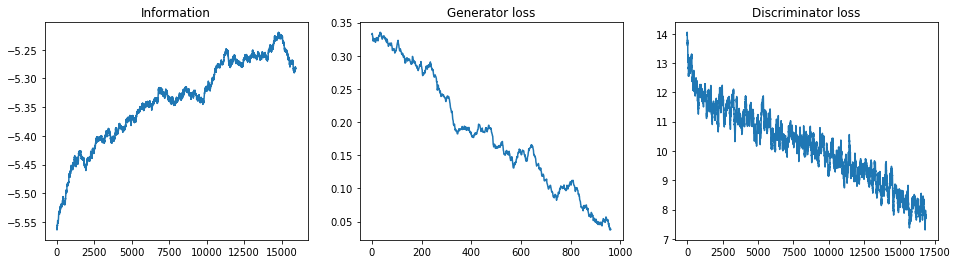

In [78]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.title("Information")
plot_smoothed(info_train_errors, n=1000);
plt.subplot(1, 3, 2)
plt.title("Generator loss")
plot_smoothed(gen_train_errors, n=100)
# plt.plot(gen_train_errors)
plt.subplot(1, 3, 3)
plt.title("Discriminator loss")
plot_smoothed(discr_train_errors, n=100)

In [60]:
accuracy_in_names()

(['friend', 'timmy'],
 ["you ' re the best friend in the whole world ! i ' m afraid you don ' t know",
  'timmy !'])

In [65]:
accuracy_in_names()

(['tom', 'son', 'butters', 'timmy'],
 ["tom , i ' m standing in south park , where the address has been reported and rapido",
  'thank you all . hey , this is a very simple answer , son . truth or human organization is',
  "ah i ' m token ' s friend . i ' m butters ' private friend in the world he",
  '_UNK_ timmy !'])

In [50]:
generator.get_perplexity_fn(bx, respondent, 20)

array(7.384118961709744)

In [69]:
import pickle
with open('test_batches.pcl', 'rb') as f:
    test_batches = pickle.load(f)

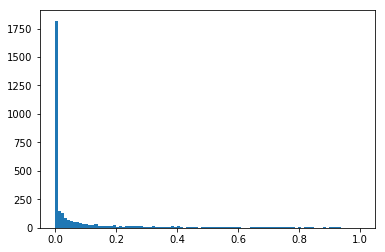

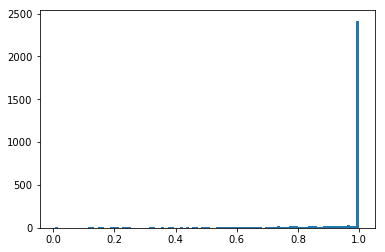

In [72]:
outs = []
real_outs = []
for bx, by, respondent in test_batches:
    outs.append(get_discr_out_on_fake(bx, respondent, 20))
    real_outs.append(get_discr_out_on_real(bx, by))
outs = np.concatenate(outs)
real_outs = np.concatenate(real_outs)
plt.hist(outs, bins=100);
plt.show()
plt.hist(real_outs, bins=100);
plt.show()

In [73]:
from sklearn.metrics import roc_auc_score
roc_auc_score(len(outs) * [0] + len(real_outs) * [1], np.concatenate([outs, real_outs]))

0.98963281250000001

In [81]:
for i in range(10):
    name_id = 439
    name_batch =  phrase_to_matrix([["Hello", "Hello", "What is your name ? "]], max_len=20)
    #att_seqs = attention_discriminator.get_attention_fake(name_batch, [name_id], 20)
    gen_answer, gen_reward = test_discr_fn(name_batch, [name_id], 20)
    gen_answer = ' '.join(phrase_from_idx(gen_answer[0], crop_by_eos=True))
    print gen_reward[0, 1]
    print "GENERATED: ", gen_answer

0.0768643
GENERATED:  oho kay , others , you don ' t want to learn all your stupid stuff like that .
0.374519
GENERATED:  my name is billy , and i feel like i ' m deep inside some space ship . if i
3.82923e-09
GENERATED:  jesus christ . it was a real disease .
0.00285682
GENERATED:  skeeter . u - uh . it looks like the red mega man ' s pet won by a shark
0.0367845
GENERATED:  my name is cameron , and this is my name . . . my b - b - bu -
1.01067e-08
GENERATED:  this is earth day world
1.73698e-10
GENERATED:  my name is randy marsh . my name is sharon .
2.36476e-16
GENERATED:  hyeah !
9.39646e-10
GENERATED:  kyle broflovski . he ' s a very smart boy .
4.76818e-11
GENERATED:  peter


In [68]:
temperature.set_value(np.float32(0.5))
for i in range(5):
    print(generator.reply(["Hello!", "Hello", "What is your name ?"], 439))
    
temperature.set_value(np.float32(1))

my name is stan marsh . i ' m from the future .
kyle broflovski .
my name is randy marsh . i ' m a man from a long line . i ' m a
kyle broflovski .
my name is randy marsh . i ' m from the future .


In [58]:
gen_answers, gen_rewards = test_discr_fn(one_batch[0], one_batch[2], 20)
gen_answers = [' '.join(phrase_from_idx(gen_answers[j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
answers =  [' '.join(phrase_from_idx(one_batch[1][j], crop_by_eos=True)) for j in range(len(one_batch[1]))]
discr_reward = gen_rewards[:, 1]
#att_seqs = attention_discriminator.get_attention_real(one_batch[0], one_batch[1])
for i in range(one_batch[0].shape[0]):
    print discr_reward[i]
    print ' '.join(phrase_from_idx(one_batch[0][i]))
    print "REAL: ", answers[i]
    print "GENERATED: ", gen_answers[i]

1.89896e-10
what ? _EOS_ ( no , fuck you ! she ' s my girl ! ) _EOS_ you ' re
REAL:  this must be decided at the _UNK_ in _UNK_ !
GENERATED:  i ' m just an ignorant asshole like you .
2.31016e-13
my god , you ' re right . _EOS_ _EOS_ how ' s it goin ' , fat ass ?
REAL:  i haven ' t made any money yet .
GENERATED:  wait , what a bunch of five - darra
0.00412678
" give a hoot , don ' t pollute , " m ' kay . _EOS_ hi , i '
REAL:  alright kids , time to split up and go into the forest . let ' s divide you all up
GENERATED:  please , give me a call . i ' ve got some chili fudge in your mom ' s office
3.03877e-14
whoa . . . _EOS_ i have been sent from japan to serve as your personal robot . _EOS_ you
REAL:  yes . i will be your new best friend .
GENERATED:  now drive faster !
3.49266e-06
all right , let ' s get the hell out of here ! _EOS_ _EOS_ aah ! run , dude
REAL:  k ' plagh ! k ' plagh !
GENERATED:  did he ever do that ? do you think he knows what it means ? !
0.410501
that ' s better .

# Stuff

In [ ]:
from agentnet.learning.generic import get_values_for_actions

class conv_log_gan_trainer:    
    
    rewards = T.log(conv_discriminator.output_on_fake[:, 1])
    baseline = T.log(conv_discriminator.output_on_greedy_fake[:, 1])

    advantage = rewards - baseline

    policy = T.maximum(generator.probs, 1e-10)
    log_policy = T.log(policy)
    
    #policy gradient
    J = log_policy * advantage[:,None]
    
    loss = -J.mean()
    
    
    #regularize with negative entropy
    entropy = -T.sum(policy * log_policy, axis=-1)

    loss -= 0.01 * entropy.mean()

    grads = T.grad(loss, generator.weights)
    grads = lasagne.updates.total_norm_constraint(grads, 10)

    updates = lasagne.updates.adam(grads, model.weights, learning_rate=1e-5) 

    train_step = theano.function([encoder.input_sequence],loss,
                                 updates = model.auto_updates+model.greedy_auto_updates+updates)

In [120]:
actions, policy = generator.out[:, :-1], generator.probs[:, :-1]
policy = T.maximum(policy, 1e-10)

def one_step_reward(step_idx, gen_out):
    return get_output(conv_discriminator.discr, 
                                            {conv_discriminator.question: encoder.input_phrase,
                                             conv_discriminator.answer: gen_out[:, :step_idx+1], 
                                          })[:, 1]

def one_step_reward_and_value(step_idx, gen_out):
    assert False, "Implement me"
    #output_on_fake = get_output(discr, {question: encoder.input_phrase, answer: generator.out})
    #output_on_real = get_output(discr, {question: encoder.input_phrase, answer: reference_answers_var})
    curr_reward, state_value = get_output([conv_discriminator.l_prob, baseline_discriminator.l_prob], 
                                            {discriminator.l_in: generator.out[:, :step_idx+1], 
                                            discriminator.l_mask: get_mask_from_end_indicator(
                                                                       T.eq(generator.out[:, :step_idx+1], EOS_ix)),
                                           baseline_discriminator.l_in: gen_out[:, :step_idx+1], 
                                            baseline_discriminator.l_mask: get_mask_from_end_indicator(
                                                                           T.eq(gen_out[:, :step_idx+1], EOS_ix))
                                          })
    
    return (curr_reward[:, 1], state_value[:, 1])

In [125]:
rewards, scan_updates = theano.scan(one_step_reward, sequences=[theano.tensor.arange(seq_len)],
                                       non_sequences=[actions])
rewards = rewards.T[:, :-1]


In [126]:
from agentnet.learning import reinforce

reinforce_loss = reinforce.get_elementwise_objective(policy, actions, rewards).mean()
gen_updates = lasagne.updates.adam(reinforce_loss, generator.weights, learning_rate=0.001)
train_pg_step = theano.function([encoder.input_phrase, person_id_var, generator.n_steps],
                                rewards.mean(), updates=generator.recurrence.get_automatic_updates() + gen_updates,
                              allow_input_downcast=True)

In [110]:
bx.shape, by.shape, respondent.shape

((32, 20), (32, 20), (32,))

In [30]:
perplexity_values = []
for bx, by, respondent in generate_data(data_rows, speakers_list=speakers_list, n_iter=100, max_len=seq_len):
    perplexity_values.append(generator.get_perplexity_fn(bx, respondent, 20))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [82]:
test_batches = [[bx, by, respondent] for bx, by, respondent in 
                generate_data(data_rows, speakers_list=speakers_list, n_iter=100, max_len=seq_len)]

/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [83]:
# with open('test_batches.pcl', 'wb') as f:
#     pickle.dump(test_batches, f)

In [37]:
with open('test_batches.pcl', 'rb') as f:
    test_batches = pickle.load(f)

In [85]:
perplexity_values = []

In [89]:
for bx, by, respondent in test_batches:
    perplexity_values.append(generator.get_perplexity_fn(bx, respondent, 20))

In [90]:
np.mean(perplexity_values)

10.436289622399606

In [28]:
persona_based_loss = []


In [105]:
gen_train_errors = []
discr_train_errors = []

In [51]:
name_to_ix['Mother']

1266

In [52]:
mother_phrases_idxs = []
for i, idx in enumerate(speakers_list):
    if idx == 1266:
        mother_phrases_idxs.append(i)

In [53]:
mother_phrases_idxs

[3079,
 3082,
 3084,
 6993,
 9316,
 25085,
 25089,
 26662,
 26664,
 26666,
 26668,
 26670,
 26675,
 48338,
 48340,
 60755,
 62422,
 72981,
 72983,
 74786]

In [54]:
np.array(mother_phrases_idxs) - 3

array([ 3076,  3079,  3081,  6990,  9313, 25082, 25086, 26659, 26661,
       26663, 26665, 26667, 26672, 48335, 48337, 60752, 62419, 72978,
       72980, 74783])

In [55]:
mother_contexts = [[data_rows[idx-3], data_rows[idx-2], data_rows[idx-1]] for idx in mother_phrases_idxs]

In [57]:
temperature.set_value(0.5)
for i in range(len(mother_contexts)):
    phrases = [' '.join(map(tokens.__getitem__, mother_contexts[i][j])) for j in range(3)]
    print 'CONTEXT'
    for j in range(3):
        print phrases[j]
    print 'ANSWER'
    print 'OUR:', generator.reply(phrases, 1266)
    print 'REAL:', ' '.join(map(tokens.__getitem__, data_rows[mother_phrases_idxs[i]]))

CONTEXT
_UNK_ . could you have them turn up the light s a little , please ? [ the waiter goes away ] _EOS_
oh , look at it , gerald . all the new families moving in . [ a new mexican restaurant - _UNK_ _UNK_ - is having its grand opening across the street ] our little town is all grown up . _EOS_
where ' s that other taco plate ? we need it now . _EOS_
ANSWER
OUR: you want us to tell you what we want to do ?
REAL: i ' m a little overwhelmed . _EOS_
CONTEXT
i ' m a little overwhelmed . _EOS_
i know . but we ' ve put everything into moving here and starting this business , and we have to be impressive . [ walks up to the boy and gets down on one knee ] _UNK_ , you must help your mama however you can . we ' re not going back to that miserable place ! _EOS_
i don ' t wanna go back either . _EOS_
ANSWER
OUR: i ' m not sure .
REAL: okay , done . _EOS_
CONTEXT
i don ' t wanna go back either . _EOS_
okay , done . _EOS_
great ! [ rises and goes for the plates ] we really have to impress this cu

In [628]:
temperature.set_value(0.5)
for i in range(len(mother_contexts)):
    phrases = [' '.join(map(tokens.__getitem__, mother_contexts[i][j])) for j in range(3)]
    print 'CONTEXT'
    for j in range(3):
        print phrases[j]
    print 'ANSWER'
    print 'OUR:', generator.reply(phrases, 1266)
    print 'REAL', ' '.join(map(tokens.__getitem__, data_rows[mother_phrases_idxs[i]]))

CONTEXT
_UNK_ . could you have them turn up the light s a little , please ? [ the waiter goes away ] _EOS_
oh , look at it , gerald . all the new families moving in . [ a new mexican restaurant - _UNK_ _UNK_ - is having its grand opening across the street ] our little town is all grown up . _EOS_
where ' s that other taco plate ? we need it now . _EOS_
ANSWER
OUR: hey , you can ' t just leave the kids alone . it ' s the last time i came
REAL i ' m a little overwhelmed . _EOS_
CONTEXT
i ' m a little overwhelmed . _EOS_
i know . but we ' ve put everything into moving here and starting this business , and we have to be impressive . [ walks up to the boy and gets down on one knee ] _UNK_ , you must help your mama however you can . we ' re not going back to that miserable place ! _EOS_
i don ' t wanna go back either . _EOS_
ANSWER
OUR: what ? clyde ? clyde ? clyde ? clyde ? timmy ! you have to come out of the closet
REAL okay , done . _EOS_
CONTEXT
i don ' t wanna go back either . _EOS_
oka

In [ ]:
temperature.set_value(0.5)
for i in range(len(mother_contexts)):
    phrases = [' '.join(map(tokens.__getitem__, mother_contexts[i][j])) for j in range(3)]
    print 'CONTEXT'
    for j in range(3):
        print phrases[j]
    print 'ANSWER'
    print 'OUR:', generator.reply(phrases, 1266)
    print 'REAL', ' '.join(map(tokens.__getitem__, data_rows[mother_phrases_idxs[i]]))

In [615]:
data_rows[mother_phrases_idxs]

array([[14726, 20, 18026, 501, 17596, 21478, 19, 0],
       [21005, 11, 9040, 19, 0], [1648, 21063, 16, 0],
       [1, 11, 33406, 11, 4475, 10, 0],
       [20971, 12744, 11, 16499, 11, 14299, 19, 0], [28501, 16, 0],
       [28501, 16, 0], [0], [20971, 645, 29290, 11, 10417, 8960, 19, 0],
       [20971, 14299, 32704, 33467, 20205, 15711, 501, 19655, 651, 29541, 19, 0],
       [32627, 11, 32704, 20, 25698, 29957, 19723, 651, 30032, 15024, 29957, 33159, 16, 0],
       [0], [1528, 32736, 33467, 20, 24193, 9040, 31664, 29972, 0],
       [501, 17818, 20924, 22094, 4926, 29957, 12546, 12374, 1528, 9026, 20, 29407, 16710, 19, 0],
       [20971, 33406, 11, 9518, 21063, 20924, 29972, 20, 25698, 501, 3492, 19, 0],
       [32704, 1885, 30015, 8981, 16, 0], [13955, 7782, 19, 0],
       [33406, 16, 0], [33406, 11, 31917, 20, 25698, 1970, 27800, 19, 0],
       [21814, 29972, 33481, 19, 0]], dtype=object)

In [618]:
for row in data_rows[mother_phrases_idxs]:
    print ' '.join(map(tokens.__getitem__, row))

i ' m a little overwhelmed . _EOS_
okay , done . _EOS_
another one ? _EOS_
_UNK_ , yes , but - _EOS_
oh golly , kevin , honey . _EOS_
stephen ? _EOS_
stephen ? _EOS_
_EOS_
oh absolutely sweetheart , everybody does . _EOS_
oh honey what you need is a more absorbent tampon . _EOS_
well , what ' s the most absorbent thing in the world ? _EOS_
_EOS_
and when you ' re done using them _EOS_
a lot of people carry the ginger gene and don ' t know . _EOS_
oh yes , each one of them ' s a blessing . _EOS_
what are they doing ? _EOS_
here davey . _EOS_
yes ? _EOS_
yes , vernon ' s around somewhere . _EOS_
pass them yourself . _EOS_
